In [1]:
MODELS_FROM_FILE = 1
IMPORTANCES_FROM_FILE = 0

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif

from sklearn.pipeline import make_pipeline

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, recall_score, precision_score, balanced_accuracy_score, f1_score, roc_auc_score, fbeta_score, make_scorer, roc_curve, precision_recall_curve, accuracy_score
from sklearn.metrics import PrecisionRecallDisplay, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

    
pd.set_option("display.max_columns", None)
pd.set_option('max_colwidth', None)


data_intermediate_dir = "data/intermediate/"
item_lvl_w_imp = pd.read_csv(data_intermediate_dir + "item_lvl_w_impairment.csv")


# Prepare input and ouptut column names

diag_cols = [x for x in item_lvl_w_imp.columns if x.startswith("Diag: ")] # All diagnosis columns

input_cols = [x for x in item_lvl_w_imp.columns if 
                       not x.startswith("Diag: ") 
                       and not x.startswith("WIAT")
                       and not x.startswith("WISC")
                       and not x in ["WHODAS_P,WHODAS_P_Total", "CIS_P,CIS_P_Score", "WHODAS_SR,WHODAS_SR_Score", "CIS_SR,CIS_SR_Total"]] # Input columns are all columns except Diagnosis, WIAT, and WISC columns

learning_disorder_cols = [
    "Diag: Specific Learning Disorder with Impairment in Reading",
    "Diag: Specific Learning Disorder with Impairment in Mathematics",
    "Diag: Intellectual Disability-Mild",
    "Diag: Borderline Intellectual Functioning",
    "Diag: Specific Learning Disorder with Impairment in Written Expression"
]

# Separate test set for all diagnoses

# Shuffle the dataset 
shuffle_df = item_lvl_w_imp.sample(frac=1, random_state=42)

# Define a size for the train set 
train_size = int(0.7 * len(item_lvl_w_imp))

# Split the dataset 
train_set = shuffle_df[:train_size]
test_set = shuffle_df[train_size:] # Don't touch this until the end

# Train_train and Validation set
# Define a size for your train_train set 
train_train_size = int(0.7 * len(train_set))

# Split your dataset 
train_train_set = train_set[:train_train_size]
val_set = train_set[train_train_size:]

In [2]:
def get_base_models_and_param_grids():
    
    # Define base models
    dt = DecisionTreeClassifier()
    rf = RandomForestClassifier()
    svc = svm.SVC()
    lr = LogisticRegression(solver="liblinear")
    
    # Impute missing values
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    
    # Standardize data
    scaler = StandardScaler()

    # Make pipelines
    dt_pipe = make_pipeline(imputer, scaler, dt)
    rf_pipe = make_pipeline(imputer, scaler, rf)
    svc_pipe = make_pipeline(imputer, scaler, svc)
    lr_pipe = make_pipeline(imputer, scaler, lr)
    
    # Define parameter grids to search for each pipe
    from scipy.stats import loguniform, uniform
    dt_param_grid = {
        "decisiontreeclassifier__min_samples_split": np.random.randint(2, 20, 30),
        "decisiontreeclassifier__max_depth": np.random.randint(1, 30, 30),
        "decisiontreeclassifier__min_samples_leaf": np.random.randint(1, 20, 30),
        "decisiontreeclassifier__max_leaf_nodes": np.random.randint(2, 50, 30),
        "decisiontreeclassifier__criterion": ['gini', 'entropy'],
        "decisiontreeclassifier__class_weight": ['balanced', None]
    }
    rf_param_grid = {
        'randomforestclassifier__max_depth' : np.random.randint(5, 150, 30),
        'randomforestclassifier__min_samples_split': np.random.randint(2, 50, 30),
        'randomforestclassifier__n_estimators': np.random.randint(50, 400, 10),
        'randomforestclassifier__min_samples_leaf': np.random.randint(1, 20, 30),
        'randomforestclassifier__max_features': ['auto', 'sqrt', 'log2', 0.25, 0.5, 0.75, 1.0],
        'randomforestclassifier__criterion': ['gini', 'entropy'],
        'randomforestclassifier__class_weight':["balanced", "balanced_subsample", None],
        "randomforestclassifier__class_weight": ['balanced', None]
    }
    svc_param_grid = {
        'svc__C': loguniform(1e-03, 1e+02),
        'svc__gamma': loguniform(1e-03, 1e+02),
        'svc__degree': uniform(2, 5),
        'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        "svc__class_weight": ['balanced', None]
    }
    lr_param_grid = {
        'logisticregression__C': loguniform(1e-5, 100),
        'logisticregression__penalty': ['l1', 'l2']
    }
    
    base_models_and_param_grids = [
        (dt_pipe, dt_param_grid),
        (rf_pipe, rf_param_grid),
        (svc_pipe, svc_param_grid),
        (lr_pipe, lr_param_grid),
    ]
    
    return base_models_and_param_grids

def get_best_classifier(base_model, grid, output_col):
    cv = StratifiedKFold(n_splits=3)
    rs = RandomizedSearchCV(estimator=base_model, param_distributions=grid, cv=cv, scoring="roc_auc", n_iter=100, n_jobs = -1)
    
    rs.fit(train_set[input_cols], train_set[output_col]) # On train_set, not train_train_set because do cross-validation
    
    best_estimator = rs.best_estimator_
    best_score = rs.best_score_
    
    # If chosen model is SVM add a predict_proba parameter (not needed for grid search, and slows it down significantly)
    if 'svc' in best_estimator.named_steps.keys():
        best_estimator.set_params(svc__probability=True)

    return (best_estimator, best_score)

In [3]:
# Calculate probability threshold
beta = 2.5
def calculate_threshold(classifier, output_col, b = beta):
    from numpy import nanargmax
    
    # Fit model on validation set
    classifier.fit(train_train_set[input_cols], train_train_set[output_col])
    
    # Get predicted probabilities values
    y_val_pred_prob = classifier.predict_proba(val_set[input_cols])
    
    # Calculate precision_recall_curve
    precisions, recalls, thresholds = precision_recall_curve(val_set[output_col], y_val_pred_prob[:,1])
    
    # Calculate F-scores
    fscores = ((1+b**2) * precisions * recalls) / ((b**2 * precisions) + recalls)
    
    # Locate the index of the largest F-score
    ix = nanargmax(fscores)
    
    threshold = thresholds[ix]
    
    return threshold

In [4]:
def find_best_classifier_for_diag(diag):
    best_score = 0
    best_classifier = None
    base_models_and_param_grids = get_base_models_and_param_grids()
    for (base_model, grid) in base_models_and_param_grids:
        best_classifier_for_model, best_score_for_model = get_best_classifier(base_model, grid, diag)
        if best_score_for_model > best_score:
            best_classifier = best_classifier_for_model
            best_score = best_score_for_model
    return best_classifier

In [5]:
# Check how many diagnoses passed the threshold of 50 positive cases
counter = 0
for diag in diag_cols:
    if item_lvl_w_imp[diag].sum() > 50:
        counter += 1
print("Diagnoses with over 50 positive cases: ", counter)

# Check which learning diagnoses didn't pass threshold of 50 positive cases
print("Learning diagnoses with over 50 positive cases: ")
for diag in diag_cols:
    if item_lvl_w_imp[diag].sum() <= 50 and diag in learning_disorder_cols:
        print(diag)      

Diagnoses with over 50 positive cases:  21
Learning diagnoses with over 50 positive cases: 
Diag: Intellectual Disability-Mild
Diag: Borderline Intellectual Functioning


In [6]:
if MODELS_FROM_FILE == 0:
    best_classifiers = {}
    for diag in diag_cols:
        if item_lvl_w_imp[diag].sum() > 50: # Don't use diagnoses if there are less than 50 positive examples
            best_classifier_for_diag = find_best_classifier_for_diag(diag)
            threshold = calculate_threshold(best_classifier_for_diag, diag, beta)
            best_classifiers[diag] = (best_classifier_for_diag, threshold)
    print(best_classifiers)

In [7]:
# Find best thresholds
def find_best_thresholds(beta=beta):
    best_thresholds = {}
    for diag in diag_cols:
        if item_lvl_w_imp[diag].sum() > 50: # Don't use diagnoses if there are less than 50 positive examples
            best_classifier_for_diag = best_classifiers[diag][0]
            threshold = calculate_threshold(best_classifier_for_diag, diag, beta)
            best_thresholds[diag] = threshold
    print(best_thresholds)
    return best_thresholds

if MODELS_FROM_FILE == 0:
    best_thresholds = find_best_thresholds(beta=beta)

In [8]:
from joblib import dump, load
if MODELS_FROM_FILE == 0:
    # Save best classifiers and thresholds - best parameters, and the classifyer objects themselves
    best_classifiers_df = pd.DataFrame(best_classifiers).T.reset_index()
    best_classifiers_df.columns = ["Diag", "Best Estimator", "Best Threshold"]
    display(best_classifiers_df)
    best_classifiers_df.to_csv("best-estimators-diag-item-lvl.csv")

    dump(best_classifiers, 'best-classifiers-diag-item-lvl.joblib', compress=1)
    dump(best_thresholds, 'best-thresholds-diag-item-lvl.joblib', compress=1)

In [9]:
if MODELS_FROM_FILE == 1:
    best_classifiers = load('best-classifiers-diag-item-lvl.joblib')
    best_thresholds = load('best-thresholds-diag-item-lvl.joblib')

In [10]:
import math
metric_names = ['TP','TN','FP','FN','Prevalence','Accuracy','Precision','NPV','FDR','FOR','check_Pos','check_Neg','Recall','FPR','FNR','TNR','check_Pos2','check_Neg2','LR+','LR-','DOR','F1','FBeta','MCC','BM','MK']   
def get_matrix_metrics(real_values,pred_values,beta):
    CM = confusion_matrix(real_values,pred_values)
    TN = CM[0][0]+0.01 # +0.01 To avoid division by 0 errors
    FN = CM[1][0]+0.01
    TP = CM[1][1]+0.01
    FP = CM[0][1]+0.01
    Population = TN+FN+TP+FP
    Prevalence = round( (TP+FP) / Population,2)
    Accuracy   = round( (TP+TN) / Population,4)
    Precision  = round( TP / (TP+FP),4 )
    NPV        = round( TN / (TN+FN),4 )
    FDR        = round( FP / (TP+FP),4 )
    FOR        = round( FN / (TN+FN),4 ) 
    check_Pos  = Precision + FDR
    check_Neg  = NPV + FOR
    Recall     = round( TP / (TP+FN),4 )
    FPR        = round( FP / (TN+FP),4 )
    FNR        = round( FN / (TP+FN),4 )
    TNR        = round( TN / (TN+FP),4 ) 
    check_Pos2 = Recall + FNR
    check_Neg2 = FPR + TNR
    LRPos      = round( Recall/FPR,4 ) 
    LRNeg      = round( FNR / TNR ,4 )
    DOR        = round( LRPos/LRNeg)
    F1         = round ( 2 * ((Precision*Recall)/(Precision+Recall)),4)
    FBeta      = round ( (1+beta**2)*((Precision*Recall)/((beta**2 * Precision)+ Recall)) ,4)
    MCC        = round ( ((TP*TN)-(FP*FN))/math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))  ,4)
    BM         = Recall+TNR-1
    MK         = Precision+NPV-1   
    
    mat_met = [TP,TN,FP,FN,Prevalence,Accuracy,Precision,NPV,FDR,FOR,check_Pos,check_Neg,Recall,FPR,FNR,TNR,check_Pos2,check_Neg2,LRPos,LRNeg,DOR,F1,FBeta,MCC,BM,MK]
    return (mat_met)

In [11]:
def get_metrics(classifier, threshold, output_col, input_cols, validation_or_test = "validation", print_output_flag = 0):
    input_cols = input_cols
    
    if validation_or_test == "test":
        x = test_set[input_cols]
        y = test_set[output_col]
    else: 
        x = val_set[input_cols]
        y = val_set[output_col]
        
    y_pred_prob = classifier.predict_proba(x)
    y_pred = (y_pred_prob[:,1] >= threshold).astype(bool) 
    
    roc_auc = roc_auc_score(y, y_pred_prob[:,1])
    
    metrics = get_matrix_metrics(y, y_pred, beta=3)
    metrics.append(roc_auc)
    
    if print_output_flag:
        print(output_col)
        
        # Display confusion matrix
        cm = confusion_matrix(y, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.show()

        # Display the ROC curve 
        fpr, tpr, thresholds = roc_curve(y, y_pred_prob[:,1])
        plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
        plt.plot(fpr, tpr, marker='.', label='Model')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()
        
    return metrics

Diag: Generalized Anxiety Disorder


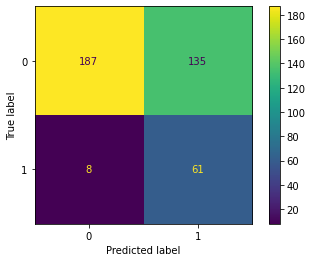

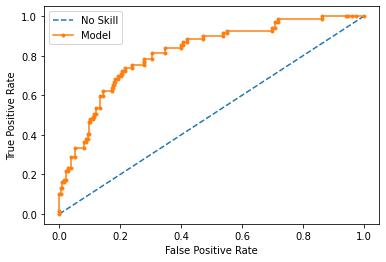

Diag: ADHD-Hyperactive/Impulsive Type


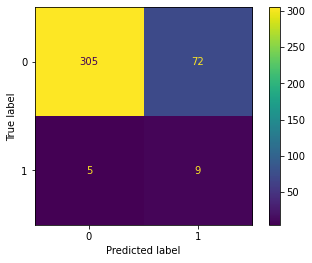

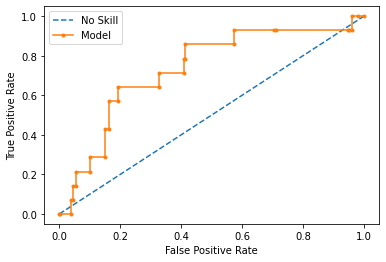

Diag: No Diagnosis Given


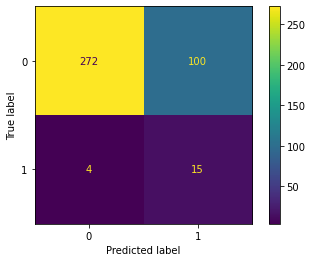

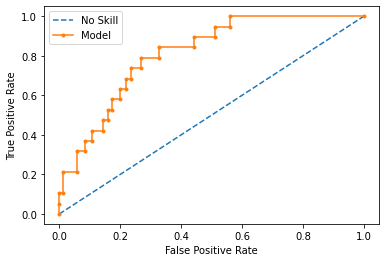

Diag: Obsessive-Compulsive Disorder


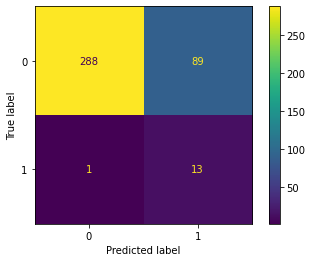

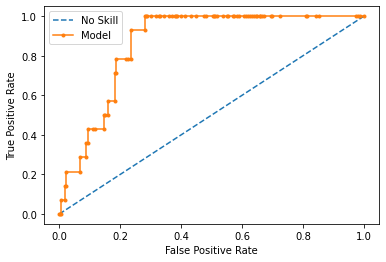

Diag: Specific Learning Disorder with Impairment in Written Expression


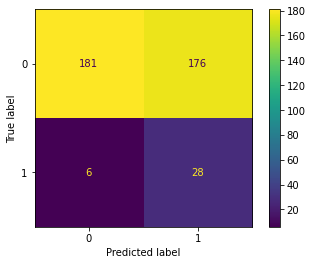

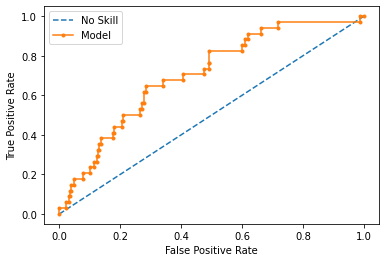

Diag: Oppositional Defiant Disorder


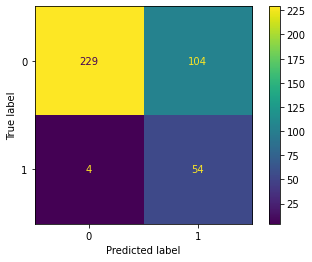

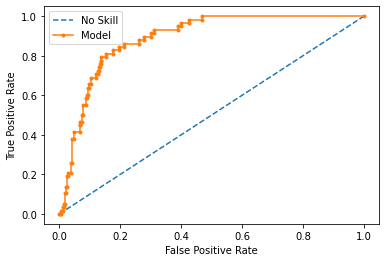

Diag: Specific Learning Disorder with Impairment in Mathematics


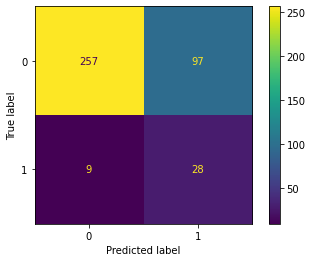

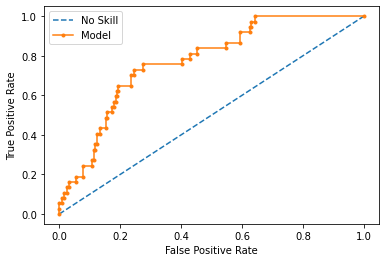

Diag: Major Depressive Disorder


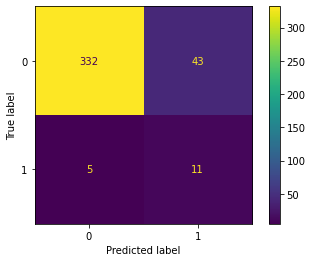

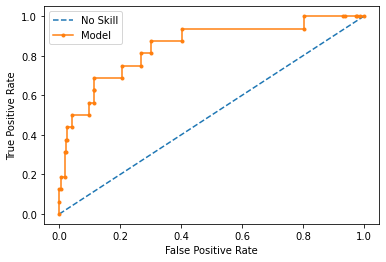

Diag: Specific Learning Disorder with Impairment in Reading


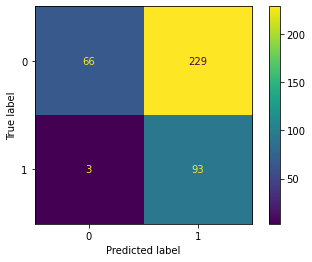

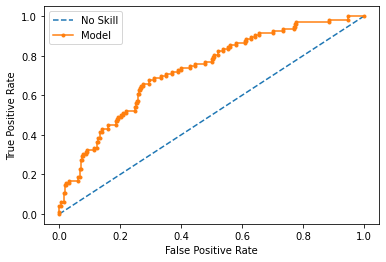

Diag: Speech Sound Disorder


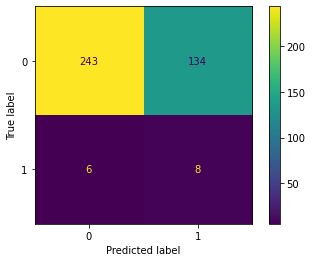

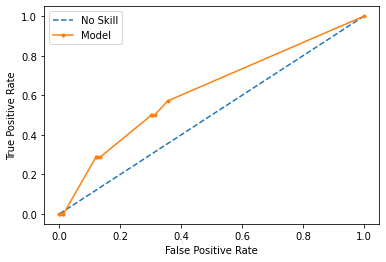

Diag: Other Specified Attention-Deficit/Hyperactivity Disorder


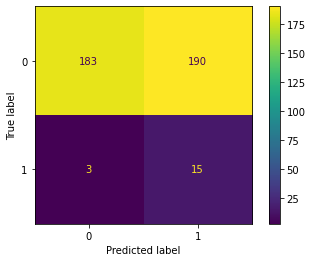

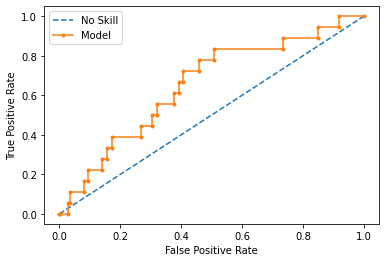

Diag: Enuresis


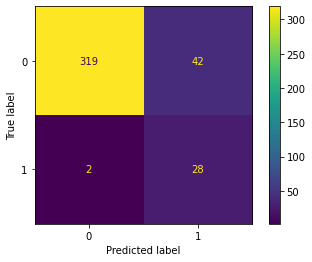

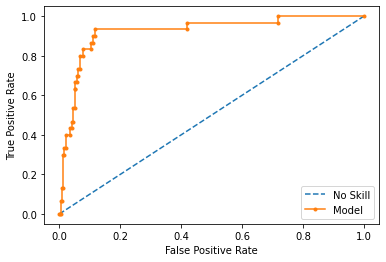

Diag: Language Disorder


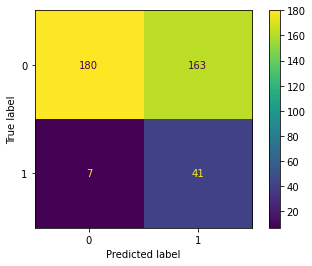

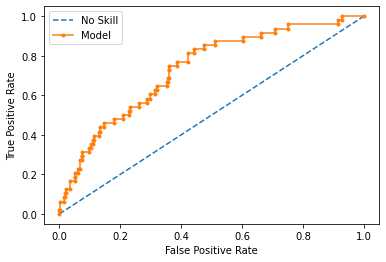

Diag: Other Specified Anxiety Disorder


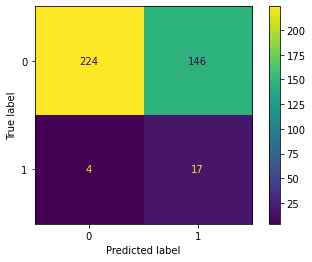

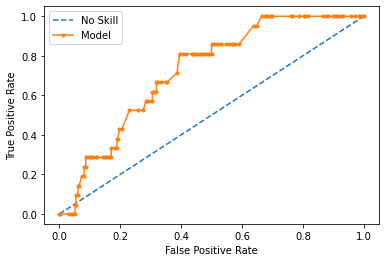

Diag: Separation Anxiety


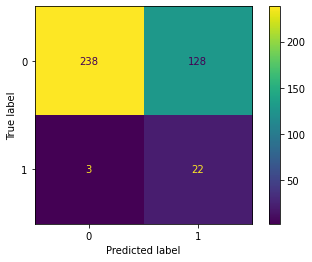

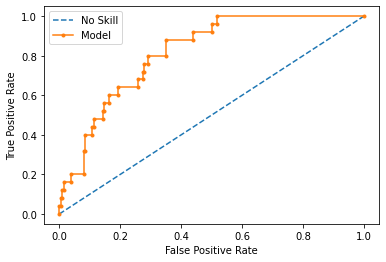

Diag: Specific Phobia


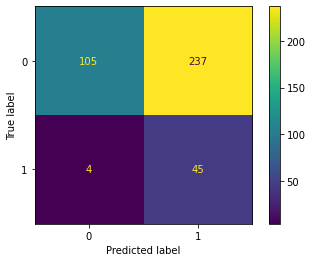

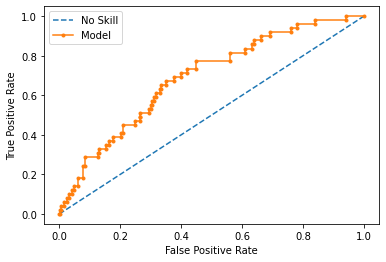

Diag: Persistent (Chronic) Motor or Vocal Tic Disorder


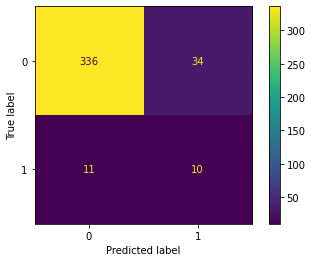

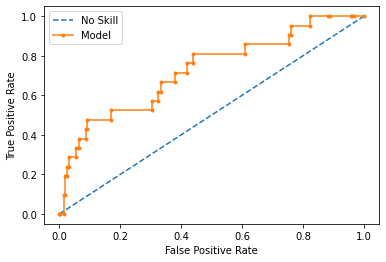

Diag: ADHD-Combined Type


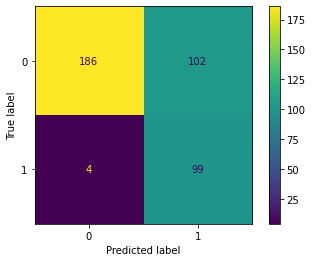

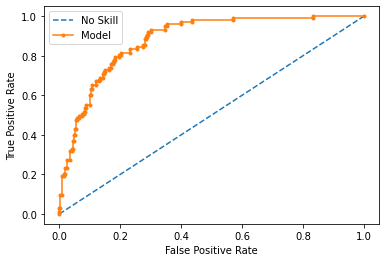

Diag: Social Anxiety (Social Phobia)


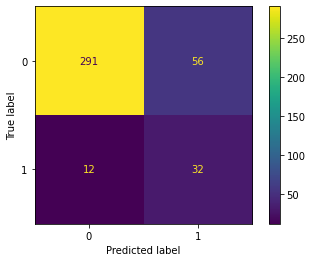

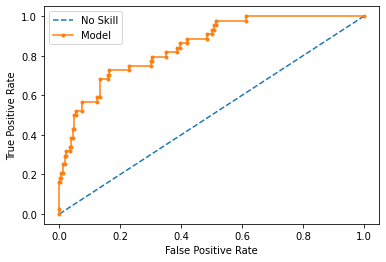

Diag: ADHD-Inattentive Type


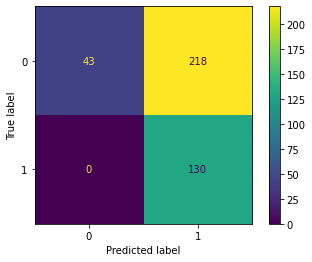

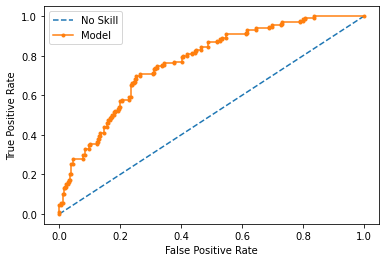

Diag: Autism Spectrum Disorder


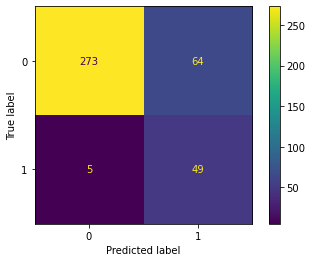

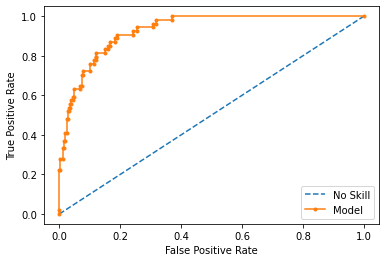

,Diag,TP,TN,FP,FN,Prevalence,Accuracy,Precision,NPV,FDR,FOR,check_Pos,check_Neg,Recall,FPR,FNR,TNR,check_Pos2,check_Neg2,LR+,LR-,DOR,F1,FBeta,MCC,BM,MK,ROC AUC
20,Diag: Autism Spectrum Disorder,49.01,273.01,64.01,5.01,0.29,0.8235,0.4336,0.9820,0.5664,0.0180,1.0,1.0,0.9073,0.1899,0.0927,0.8101,1.0,1.0,4.7778,0.1144,42,0.5868,0.8179,0.5460,0.7174,0.4156,0.930102
11,Diag: Enuresis,28.01,319.01,42.01,2.01,0.18,0.8874,0.4000,0.9937,0.6000,0.0063,1.0,1.0,0.9330,0.1164,0.0670,0.8836,1.0,1.0,8.0155,0.0758,106,0.5599,0.8233,0.5671,0.8166,0.3937,0.922992
5,Diag: Oppositional Defiant Disorder,54.01,229.01,104.01,4.01,0.40,0.7238,0.3418,0.9828,0.6582,0.0172,1.0,1.0,0.9309,0.3123,0.0691,0.6877,1.0,1.0,2.9808,0.1005,30,0.5000,0.7940,0.4481,0.6186,0.3246,0.889096
17,Diag: ADHD-Combined Type,99.01,186.01,102.01,4.01,0.51,0.7289,0.4925,0.9789,0.5075,0.0211,1.0,1.0,0.9611,0.3542,0.0389,0.6458,1.0,1.0,2.7134,0.0602,45,0.6513,0.8776,0.5349,0.6069,0.4714,0.881843
3,Diag: Obsessive-Compulsive Disorder,13.01,288.01,89.01,1.01,0.26,0.7698,0.1275,0.9965,0.8725,0.0035,1.0,1.0,0.9280,0.2361,0.0720,0.7639,1.0,1.0,3.9305,0.0943,42,0.2242,0.5701,0.2929,0.6919,0.1240,0.864153
18,Diag: Social Anxiety (Social Phobia),32.01,291.01,56.01,12.01,0.23,0.8261,0.3637,0.9604,0.6363,0.0396,1.0,1.0,0.7272,0.1614,0.2728,0.8386,1.0,1.0,4.5056,0.3253,14,0.4849,0.6611,0.4282,0.5658,0.3241,0.849817
7,Diag: Major Depressive Disorder,11.01,332.01,43.01,5.01,0.14,0.8772,0.2038,0.9851,0.7962,0.0149,1.0,1.0,0.6873,0.1147,0.3127,0.8853,1.0,1.0,5.9922,0.3532,17,0.3144,0.5555,0.3289,0.5726,0.1889,0.848000
14,Diag: Separation Anxiety,22.01,238.01,128.01,3.01,0.38,0.6649,0.1467,0.9875,0.8533,0.0125,1.0,1.0,0.8797,0.3497,0.1203,0.6503,1.0,1.0,2.5156,0.1850,14,0.2515,0.5866,0.2667,0.5300,0.1342,0.815847
0,Diag: Generalized Anxiety Disorder,61.01,187.01,135.01,8.01,0.50,0.6343,0.3112,0.9589,0.6888,0.0411,1.0,1.0,0.8839,0.4193,0.1161,0.5807,1.0,1.0,2.1080,0.1999,11,0.4603,0.7465,0.3543,0.4646,0.2701,0.815015
2,Diag: No Diagnosis Given,15.01,272.01,100.01,4.01,0.29,0.7340,0.1305,0.9855,0.8695,0.0145,1.0,1.0,0.7892,0.2688,0.2108,0.7312,1.0,1.0,2.9360,0.2883,10,0.2240,0.5245,0.2457,0.5204,0.1160,0.812394


In [12]:
# Check performance of the final model on validation set for all models

results_val_set = []
for diag in diag_cols:
    if item_lvl_w_imp[diag].sum() > 50:
        classifier = best_classifiers[diag][0]
        threshold = best_thresholds[diag]
        metrics = get_metrics(classifier, threshold, diag, input_cols, 'validation', 1)
        prevalence = item_lvl_w_imp[diag].sum()/len(item_lvl_w_imp)
        results_val_set.append([
            diag, 
            *metrics])
restults_val_set_df = pd.DataFrame(results_val_set, columns=["Diag"]+metric_names+["ROC AUC"])
restults_val_set_df.sort_values(by="ROC AUC", ascending=False)

In [13]:
# Do cross-validation to get more reliable ROC AUC scores (f1 harder to obtain with cross validation - need to change threshold)

auc_cv_mean_val_set = []
auc_cv_std_val_set = []
for diag in diag_cols:
    if item_lvl_w_imp[diag].sum() > 50:
        classifier = best_classifiers[diag][0]
        
        cv = StratifiedKFold(n_splits=5)
        auc = cross_val_score(classifier, train_set[input_cols], train_set[diag], cv=cv, scoring='roc_auc', n_jobs=-1)
        
        auc_cv_mean_val_set.append(auc.mean())
        auc_cv_std_val_set.append(auc.std())
restults_val_set_df["ROC AUC Mean CV"] = pd.Series(auc_cv_mean_val_set)
restults_val_set_df["ROC AUC Std CV"] = pd.Series(auc_cv_std_val_set)
restults_val_set_df

,Diag,TP,TN,FP,FN,Prevalence,Accuracy,Precision,NPV,FDR,FOR,check_Pos,check_Neg,Recall,FPR,FNR,TNR,check_Pos2,check_Neg2,LR+,LR-,DOR,F1,FBeta,MCC,BM,MK,ROC AUC,ROC AUC Mean CV,ROC AUC Std CV
0,Diag: Generalized Anxiety Disorder,61.01,187.01,135.01,8.01,0.50,0.6343,0.3112,0.9589,0.6888,0.0411,1.0,1.0,0.8839,0.4193,0.1161,0.5807,1.0,1.0,2.1080,0.1999,11,0.4603,0.7465,0.3543,0.4646,0.2701,0.815015,0.838482,0.020415
1,Diag: ADHD-Hyperactive/Impulsive Type,9.01,305.01,72.01,5.01,0.21,0.8030,0.1112,0.9838,0.8888,0.0162,1.0,1.0,0.6427,0.1910,0.3573,0.8090,1.0,1.0,3.3649,0.4417,8,0.1896,0.4349,0.2072,0.4517,0.0950,0.733611,0.783697,0.055558
2,Diag: No Diagnosis Given,15.01,272.01,100.01,4.01,0.29,0.7340,0.1305,0.9855,0.8695,0.0145,1.0,1.0,0.7892,0.2688,0.2108,0.7312,1.0,1.0,2.9360,0.2883,10,0.2240,0.5245,0.2457,0.5204,0.1160,0.812394,0.796679,0.039738
3,Diag: Obsessive-Compulsive Disorder,13.01,288.01,89.01,1.01,0.26,0.7698,0.1275,0.9965,0.8725,0.0035,1.0,1.0,0.9280,0.2361,0.0720,0.7639,1.0,1.0,3.9305,0.0943,42,0.2242,0.5701,0.2929,0.6919,0.1240,0.864153,0.853204,0.049807
4,Diag: Specific Learning Disorder with Impairment in Written Expression,28.01,181.01,176.01,6.01,0.52,0.5345,0.1373,0.9679,0.8627,0.0321,1.0,1.0,0.8233,0.4930,0.1767,0.5070,1.0,1.0,1.6700,0.3485,5,0.2354,0.5490,0.1864,0.3303,0.1052,0.705141,0.630509,0.068506
5,Diag: Oppositional Defiant Disorder,54.01,229.01,104.01,4.01,0.40,0.7238,0.3418,0.9828,0.6582,0.0172,1.0,1.0,0.9309,0.3123,0.0691,0.6877,1.0,1.0,2.9808,0.1005,30,0.5000,0.7940,0.4481,0.6186,0.3246,0.889096,0.878987,0.019537
6,Diag: Specific Learning Disorder with Impairment in Mathematics,28.01,257.01,97.01,9.01,0.32,0.7289,0.2240,0.9661,0.7760,0.0339,1.0,1.0,0.7566,0.2740,0.2434,0.7260,1.0,1.0,2.7613,0.3353,8,0.3457,0.6113,0.3029,0.4826,0.1901,0.772790,0.712737,0.046052
7,Diag: Major Depressive Disorder,11.01,332.01,43.01,5.01,0.14,0.8772,0.2038,0.9851,0.7962,0.0149,1.0,1.0,0.6873,0.1147,0.3127,0.8853,1.0,1.0,5.9922,0.3532,17,0.3144,0.5555,0.3289,0.5726,0.1889,0.848000,0.869961,0.017830
8,Diag: Specific Learning Disorder with Impairment in Reading,93.01,66.01,229.01,3.01,0.82,0.4067,0.2888,0.9564,0.7112,0.0436,1.0,1.0,0.9687,0.7763,0.0313,0.2237,1.0,1.0,1.2478,0.1399,9,0.4449,0.7841,0.2172,0.1924,0.2452,0.727331,0.679150,0.048691
9,Diag: Speech Sound Disorder,8.01,243.01,134.01,6.01,0.36,0.6419,0.0564,0.9759,0.9436,0.0241,1.0,1.0,0.5713,0.3554,0.4287,0.6446,1.0,1.0,1.6075,0.6651,2,0.1027,0.2986,0.0835,0.2159,0.0323,0.620121,0.746828,0.140371


In [14]:
# # Check cross-validation performance of the final model on validation set for all models to check for overfitting

# def plot_test_vs_train_scores(cv_results):
#     scores = pd.DataFrame(cv_results)[["test_score", "train_score"]]
#     display(scores)
#     scores.plot.hist(bins=50)
#     plt.xlim(0, 1)
#     plt.show()

# results_val_set = []
# for output in best_classifiers.keys():
#     print(output)
#     cv = StratifiedKFold(n_splits=5)
#     estimator = best_classifiers[output][0]
#     cv_results = cross_validate(estimator, train_set[input_cols], train_set[output], return_train_score = True, cv=cv, scoring='roc_auc')
#     metrics = [np.mean(cv_results["test_score"]), np.std(cv_results["test_score"])]
#     results_val_set.append([
#         output, 
#         *metrics])
    
#     plot_test_vs_train_scores(cv_results)
# restults_val_set_df = pd.DataFrame(results_val_set, columns=["Output"] + ["Mean R2", "Std R2"])
# restults_val_set_df

In [15]:
# Check why Enuresis is so low
diag = "Diag: Enuresis"

## Are there rows where Diag=0 if among "CBCL,CBCL_108", "SympChck,CSC_28P", "SympChck,CSC_28C" at least one is 1
print(len(item_lvl_w_imp[["Diag: Enuresis", "CBCL,CBCL_107", "CBCL,CBCL_108", "SympChck,CSC_28C"]][(item_lvl_w_imp["Diag: Enuresis"] == 0) & ((item_lvl_w_imp[["CBCL,CBCL_107", "CBCL,CBCL_108", "SympChck,CSC_28C"]] > 0).any(axis=1))].index), " / ", len(item_lvl_w_imp[item_lvl_w_imp["Diag: Enuresis"] == 0].index))

## Are there rows where Diag=1 if all "CBCL,CBCL_108", "SympChck,CSC_28P", "SympChck,CSC_28C" = 0
print(len(item_lvl_w_imp[["Diag: Enuresis", "CBCL,CBCL_107", "CBCL,CBCL_108", "SympChck,CSC_28C"]][(item_lvl_w_imp["Diag: Enuresis"] == 1) & (item_lvl_w_imp[["CBCL,CBCL_107", "CBCL,CBCL_108", "SympChck,CSC_28C"]] == 0).all(axis=1)]), " / ", len(item_lvl_w_imp[item_lvl_w_imp["Diag: Enuresis"] == 1].index))

# ==> More than a quarter positive diagnoses answered two main items negatively, lower performance is expected

display(item_lvl_w_imp[["Diag: Enuresis", "CBCL,CBCL_107", "CBCL,CBCL_108", "SympChck,CSC_28C"]].corr())

140  /  1679
48  /  183


,Diag: Enuresis,"CBCL,CBCL_107","CBCL,CBCL_108","SympChck,CSC_28C"
Diag: Enuresis,1.000000,0.220942,0.583301,0.401363
"CBCL,CBCL_107",0.220942,1.000000,0.288444,0.417686
"CBCL,CBCL_108",0.583301,0.288444,1.000000,0.575817
"SympChck,CSC_28C",0.401363,0.417686,0.575817,1.000000


Diag: Generalized Anxiety Disorder


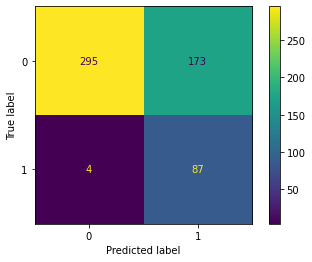

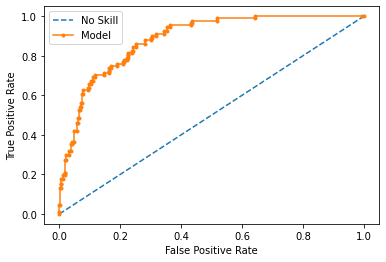

Diag: ADHD-Hyperactive/Impulsive Type


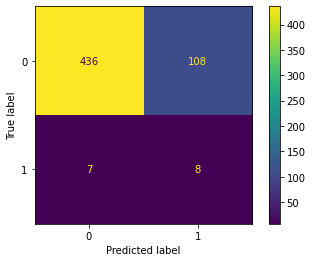

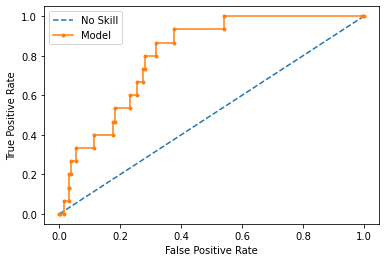

Diag: No Diagnosis Given


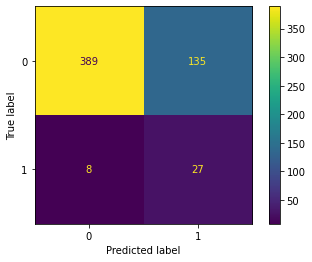

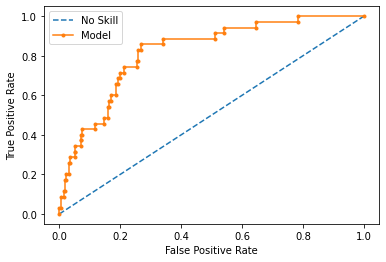

Diag: Obsessive-Compulsive Disorder


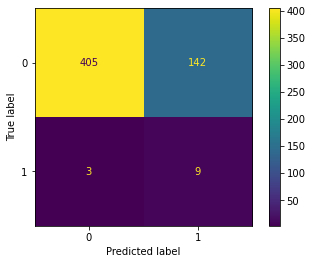

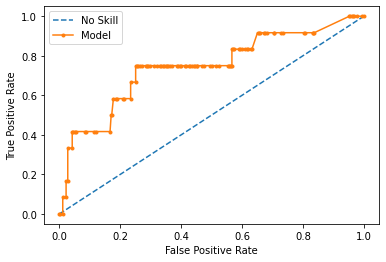

Diag: Specific Learning Disorder with Impairment in Written Expression


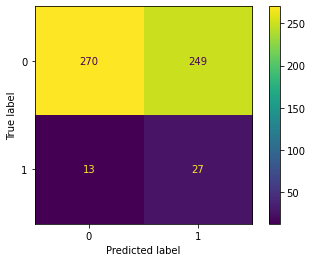

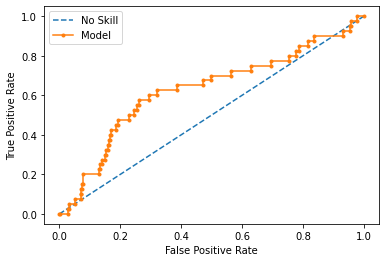

Diag: Oppositional Defiant Disorder


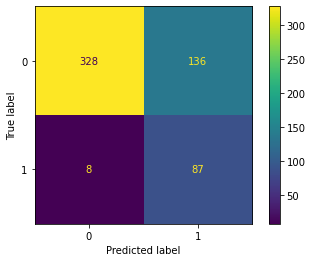

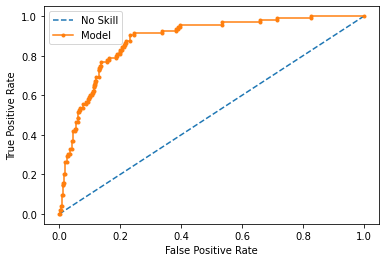

Diag: Specific Learning Disorder with Impairment in Mathematics


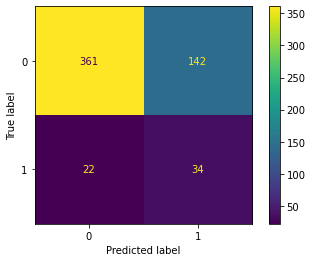

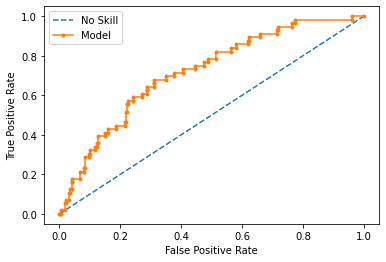

Diag: Major Depressive Disorder


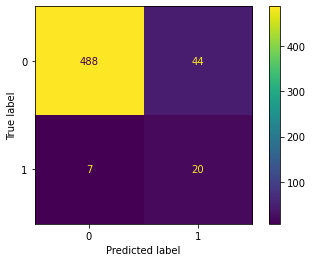

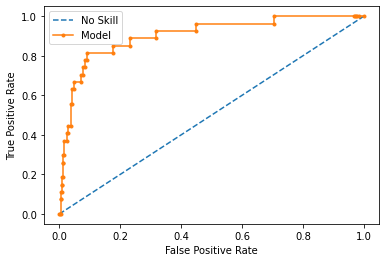

Diag: Specific Learning Disorder with Impairment in Reading


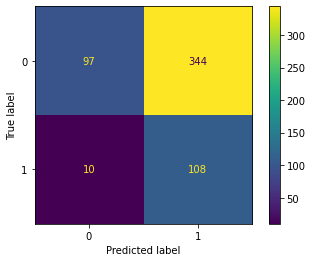

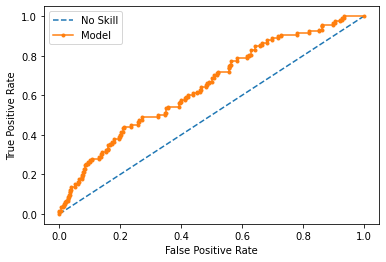

Diag: Speech Sound Disorder


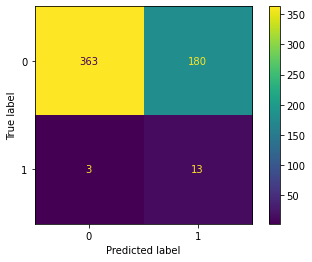

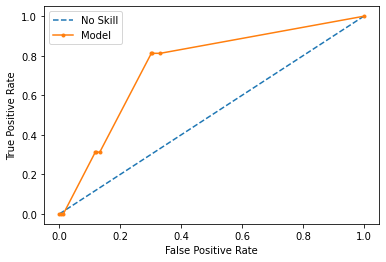

Diag: Other Specified Attention-Deficit/Hyperactivity Disorder


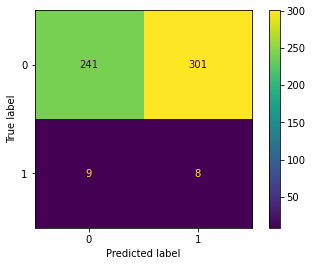

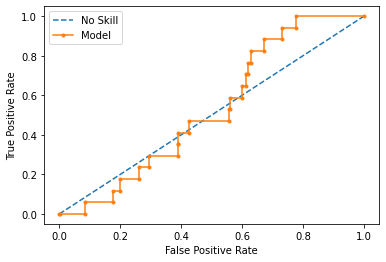

Diag: Enuresis


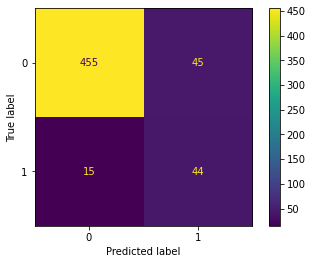

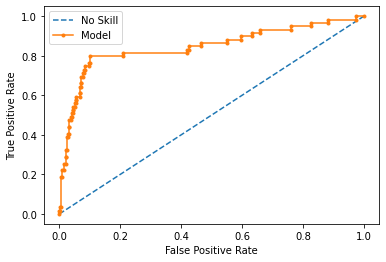

Diag: Language Disorder


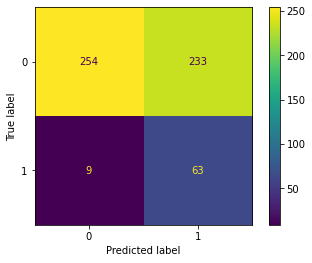

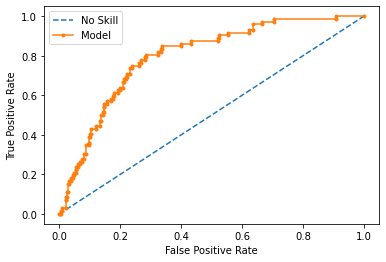

Diag: Other Specified Anxiety Disorder


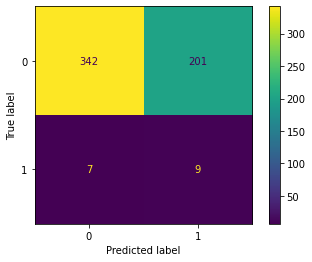

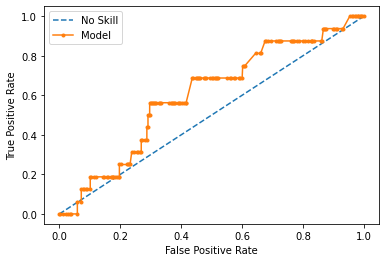

Diag: Separation Anxiety


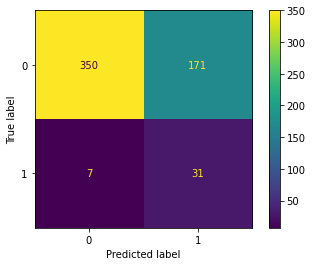

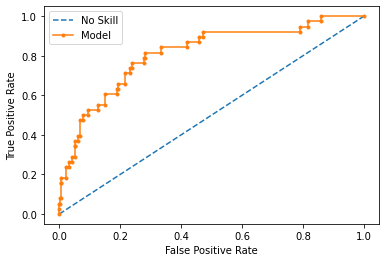

Diag: Specific Phobia


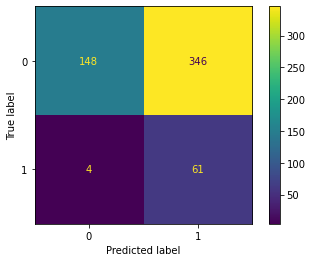

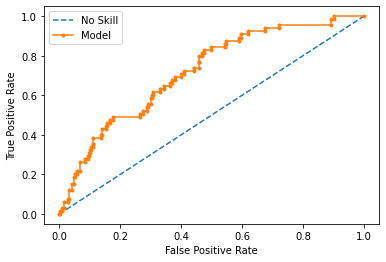

Diag: Persistent (Chronic) Motor or Vocal Tic Disorder


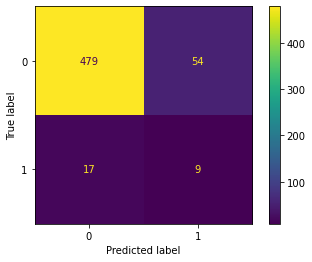

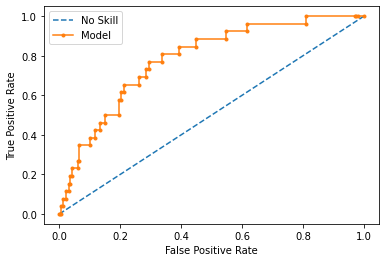

Diag: ADHD-Combined Type


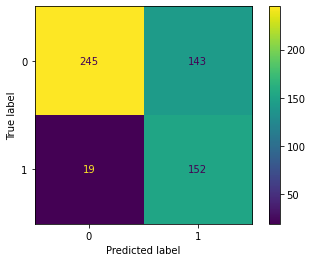

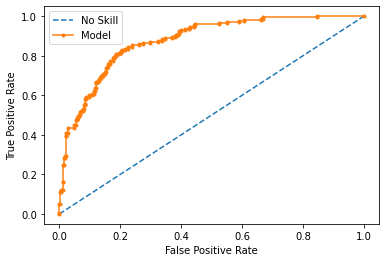

Diag: Social Anxiety (Social Phobia)


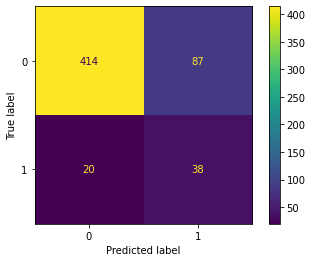

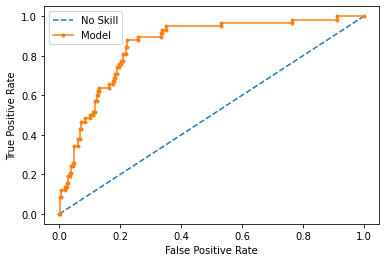

Diag: ADHD-Inattentive Type


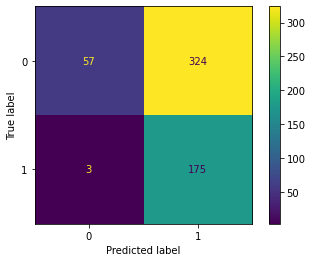

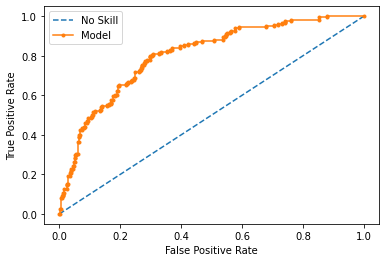

Diag: Autism Spectrum Disorder


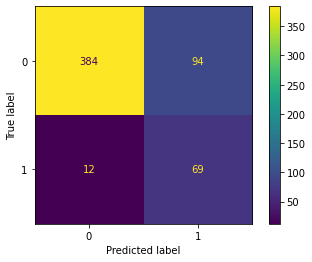

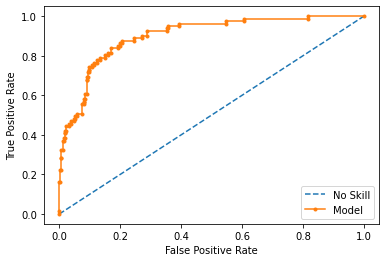

,Diag,TP,TN,FP,FN,Prevalence,Accuracy,Precision,NPV,FDR,FOR,check_Pos,check_Neg,Recall,FPR,FNR,TNR,check_Pos2,check_Neg2,LR+,LR-,DOR,F1,FBeta,MCC,BM,MK,ROC AUC
0,Diag: Generalized Anxiety Disorder,87.01,295.01,173.01,4.01,0.47,0.6834,0.3346,0.9866,0.6654,0.0134,1.0,1.0,0.9559,0.3697,0.0441,0.6303,1.0,1.0,2.5856,0.0700,37,0.4957,0.8062,0.4340,0.5862,0.3212,0.884263
1,Diag: ADHD-Hyperactive/Impulsive Type,8.01,436.01,108.01,7.01,0.21,0.7943,0.0690,0.9842,0.9310,0.0158,1.0,1.0,0.5333,0.1985,0.4667,0.8015,1.0,1.0,2.6866,0.5823,5,0.1222,0.3188,0.1335,0.3348,0.0532,0.805515
2,Diag: No Diagnosis Given,27.01,389.01,135.01,8.01,0.29,0.7442,0.1667,0.9798,0.8333,0.0202,1.0,1.0,0.7713,0.2576,0.2287,0.7424,1.0,1.0,2.9942,0.3081,10,0.2741,0.5660,0.2743,0.5137,0.1465,0.821210
3,Diag: Obsessive-Compulsive Disorder,9.01,405.01,142.01,3.01,0.27,0.7406,0.0597,0.9926,0.9403,0.0074,1.0,1.0,0.7496,0.2596,0.2504,0.7404,1.0,1.0,2.8875,0.3382,9,0.1106,0.3477,0.1601,0.4900,0.0523,0.744973
4,Diag: Specific Learning Disorder with Impairment in Written Expression,27.01,270.01,249.01,13.01,0.49,0.5313,0.0979,0.9540,0.9021,0.0460,1.0,1.0,0.6749,0.4798,0.3251,0.5202,1.0,1.0,1.4066,0.6250,2,0.1710,0.4246,0.1006,0.1951,0.0519,0.628324
5,Diag: Oppositional Defiant Disorder,87.01,328.01,136.01,8.01,0.40,0.7424,0.3901,0.9762,0.6099,0.0238,1.0,1.0,0.9157,0.2931,0.0843,0.7069,1.0,1.0,3.1242,0.1193,26,0.5471,0.8070,0.4776,0.6226,0.3663,0.883031
6,Diag: Specific Learning Disorder with Impairment in Mathematics,34.01,361.01,142.01,22.01,0.31,0.7066,0.1932,0.9425,0.8068,0.0575,1.0,1.0,0.6071,0.2823,0.3929,0.7177,1.0,1.0,2.1505,0.5474,4,0.2931,0.5000,0.2100,0.3248,0.1357,0.719149
7,Diag: Major Depressive Disorder,20.01,488.01,44.01,7.01,0.11,0.9087,0.3126,0.9858,0.6874,0.0142,1.0,1.0,0.7406,0.0827,0.2594,0.9173,1.0,1.0,8.9553,0.2828,32,0.4396,0.6514,0.4431,0.6579,0.2984,0.903926
8,Diag: Specific Learning Disorder with Impairment in Reading,108.01,97.01,344.01,10.01,0.81,0.3667,0.2389,0.9065,0.7611,0.0935,1.0,1.0,0.9152,0.7800,0.0848,0.2200,1.0,1.0,1.1733,0.3855,3,0.3789,0.7133,0.1402,0.1352,0.1454,0.647277
9,Diag: Speech Sound Disorder,13.01,363.01,180.01,3.01,0.35,0.6726,0.0674,0.9918,0.9326,0.0082,1.0,1.0,0.8121,0.3315,0.1879,0.6685,1.0,1.0,2.4498,0.2811,9,0.1245,0.3858,0.1686,0.4806,0.0592,0.746087


In [16]:
# Check performance of the final model on test set for all models

results_test_set = []
for diag in diag_cols:
    if item_lvl_w_imp[diag].sum() > 50:
        classifier = best_classifiers[diag][0]
        threshold = best_thresholds[diag]
        metrics = get_metrics(classifier, threshold, diag, input_cols, 'test', 1)
        prevalence = item_lvl_w_imp[diag].sum()/len(item_lvl_w_imp)
        results_test_set.append([
            diag, 
            *metrics])
restults_test_set_df = pd.DataFrame(results_test_set, columns=["Diag"]+metric_names+["ROC AUC"])
restults_test_set_df

### Feature importance

In [17]:
# Only use well performing diagnoses for feature selection: with (Mean CV AUC - CV AUC Std) > 0.65, F1 Beta > 0.5, and FPR < 0.6

diags_with_good_performance = list(restults_val_set_df[((restults_val_set_df["ROC AUC Mean CV"] - restults_val_set_df["ROC AUC Std CV"])>0.65) & (restults_val_set_df["FBeta"] > 0.5)  & (restults_val_set_df["FPR"] < 0.6)]["Diag"]) 
display(diags_with_good_performance)
len(diags_with_good_performance)

['Diag: Generalized Anxiety Disorder',
 'Diag: No Diagnosis Given',
 'Diag: Obsessive-Compulsive Disorder',
 'Diag: Oppositional Defiant Disorder',
 'Diag: Specific Learning Disorder with Impairment in Mathematics',
 'Diag: Major Depressive Disorder',
 'Diag: Enuresis',
 'Diag: Language Disorder',
 'Diag: Separation Anxiety',
 'Diag: ADHD-Combined Type',
 'Diag: Social Anxiety (Social Phobia)',
 'Diag: Autism Spectrum Disorder']

12

In [18]:
learning_diag_w_good_performance = [x for x in diags_with_good_performance if x in learning_disorder_cols]
learning_diag_w_good_performance

['Diag: Specific Learning Disorder with Impairment in Mathematics']

In [21]:
if IMPORTANCES_FROM_FILE == 1:
    forward_feature_objects = {}
    backward_feature_objects = {}
    try:
        forward_feature_objects = load('forward-sfs-diag-item-lvl.joblib')
    except Exception as e: print(e)

In [20]:
# Find elbow of the curve (draw a line from the first to the last point of the curve and then find the data point that is farthest away from that line) https://stackoverflow.com/questions/2018178/finding-the-best-trade-off-point-on-a-curve 
def find_elbow(curve):
    from numpy import matlib 
    n_points = len(curve)
    all_coord = np.vstack((range(n_points), curve)).T
    first_point = all_coord[0]
    line_vec = all_coord[-1] - all_coord[0]
    line_vec_norm = line_vec / np.sqrt(np.sum(line_vec**2))
    vec_from_first = all_coord - first_point
    scalar_product = np.sum(vec_from_first * np.matlib.repmat(line_vec_norm, n_points, 1), axis=1)
    vec_from_first_parallel = np.outer(scalar_product, line_vec_norm)
    vec_to_line = vec_from_first - vec_from_first_parallel
    dist_to_line = np.sqrt(np.sum(vec_to_line ** 2, axis=1))
    idx_of_best_point = np.argmax(dist_to_line)
    return idx_of_best_point + 1

def analyze_importances(importances):
    importances_list = []
    for key in importances:
        importances_list.append(importances[key]['avg_score'])
    importances_df = pd.DataFrame(importances_list, index=importances.keys(), columns=["ROC AUC"])
    display(importances_df)

    max_score = max(importances_list)
    n_cols_max_score = importances_df[importances_df["ROC AUC"] == max_score].index[0]
    print("Max score: ", max_score, " at ", n_cols_max_score, " features")
    features_up_to_max_score = importances[n_cols_max_score]["feature_names"]

    plt.figure(figsize=(16,8))
    plt.plot(importances_df)
    plt.xticks(np.arange(1,100, 3))
    plt.vlines(np.arange(1,100, 3), ymin=min(importances_list), ymax=max(importances_list), colors='purple', ls=':', lw=1)
    plt.show()
    
    optimal_nb_features = find_elbow(importances_list)
    print("Optimal number of features: ", optimal_nb_features)
    
    features_up_to_optimal = importances[optimal_nb_features]["feature_names"]
    display(features_up_to_optimal)
    
    return (features_up_to_optimal, features_up_to_max_score)

In [22]:
from mlxtend.feature_selection import SequentialFeatureSelector

if IMPORTANCES_FROM_FILE == 0:
    forward_feature_subsets = {}
    forward_feature_objects = {}
    for diag in set(diags_with_good_performance[0:2] + learning_diag_w_good_performance): # First 2 + all learning
        print(diag)
        diag_classifier = best_classifiers[diag][0]

        cv = StratifiedKFold(n_splits=3)
        sfs = SequentialFeatureSelector(diag_classifier, 
              k_features=100,
              forward=True, 
              scoring='roc_auc',
              cv=cv,
              n_jobs=-1)

        sfs = sfs.fit(train_set[input_cols], train_set[diag])

        forward_feature_subsets[diag] = sfs.subsets_
        forward_feature_objects[diag] = sfs
        
        analyze_importances(forward_feature_objects[diag].subsets_)

In [23]:
# Save importances to file
if IMPORTANCES_FROM_FILE == 0:
    dump(forward_feature_objects, 'forward-sfs-diag-item-lvl.joblib', compress=1)

In [24]:
forward_feature_objects.keys()

dict_keys(['Diag: Generalized Anxiety Disorder', 'Diag: No Diagnosis Given', 'Diag: Specific Learning Disorder with Impairment in Mathematics'])

Diag: Generalized Anxiety Disorder


,ROC AUC
1,0.780040
2,0.807573
3,0.813472
4,0.815558
5,0.818890
...,...
96,0.878712
97,0.880814
98,0.879874
99,0.880802


Max score:  0.8826808803263098  at  59  features


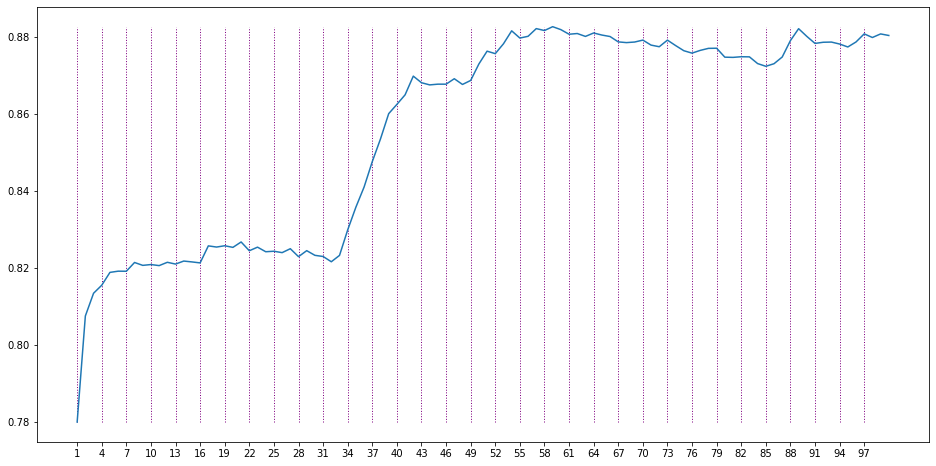

Optimal number of features:  42


('SympChck,CSC_09C',
 'SympChck,CSC_16C',
 'SympChck,CSC_16P',
 'SympChck,CSC_32C',
 'SympChck,CSC_32P',
 'SympChck,CSC_39C',
 'SympChck,CSC_53C',
 'SympChck,CSC_53P',
 'SympChck,CSC_54C',
 'SympChck,CSC_54P',
 'SympChck,CSC_55cC',
 'SympChck,CSC_55cP',
 'SympChck,CSC_55dP',
 'SympChck,CSC_55eC',
 'SympChck,CSC_55eP',
 'SympChck,CSC_55gC',
 'SympChck,CSC_55gP',
 'SympChck,CSC_55hC',
 'SympChck,CSC_55hP',
 'SympChck,CSC_55iC',
 'SympChck,CSC_55iP',
 'SCQ,SCQ_11',
 'SCQ,SCQ_40',
 'ASSQ,ASSQ_09',
 'SDQ,SDQ_08',
 'SRS,SRS_25',
 'CBCL,CBCL_02',
 'CBCL,CBCL_110',
 'CBCL,CBCL_53',
 'CBCL,CBCL_60',
 'CBCL,CBCL_67',
 'CBCL,CBCL_72',
 'CBCL,CBCL_73',
 'CBCL,CBCL_96',
 'APQ_P,APQ_P_07',
 'APQ_P,APQ_P_34',
 'PCIAT,PCIAT_06',
 'PCIAT,PCIAT_08',
 'PCIAT,PCIAT_15',
 'ESWAN,Panic_B07',
 'APQ_SR,APQ_SR_07',
 'RBS,RBS_09')

Score using all features: 
Diag: Generalized Anxiety Disorder


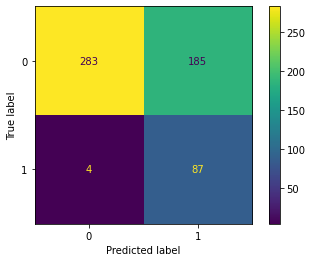

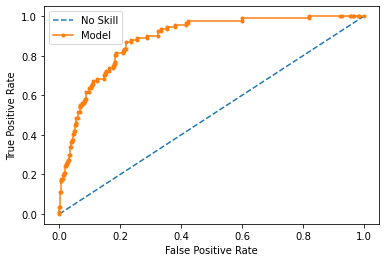

ROC AUC:  0.8855780971165587
Recall:  0.9559
Precision:  0.3199
Performance on test set using optimal number of columns: 
Diag: Generalized Anxiety Disorder


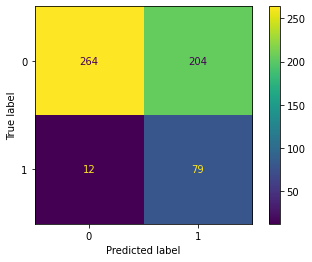

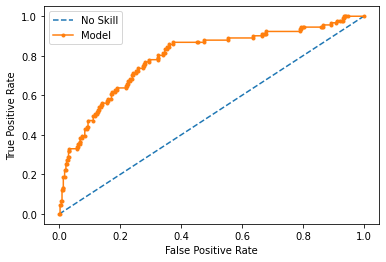

ROC AUC:  0.7932751009674087
Recall:  0.8681
Precision:  0.2792
Performance on test set using number of columns with maximum score
Diag: Generalized Anxiety Disorder


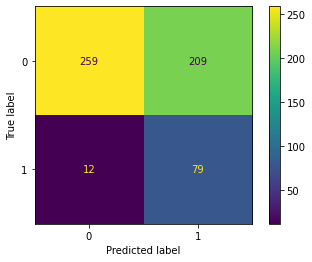

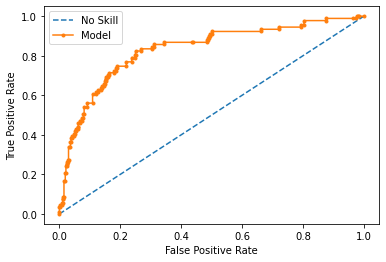

ROC AUC:  0.8326876115337655
Recall:  0.8681
Precision:  0.2743
Diag: No Diagnosis Given


,ROC AUC
1,0.750570
2,0.791797
3,0.810183
4,0.824968
5,0.840287
...,...
96,0.866913
97,0.871539
98,0.868808
99,0.867838


Max score:  0.8862182209387917  at  39  features


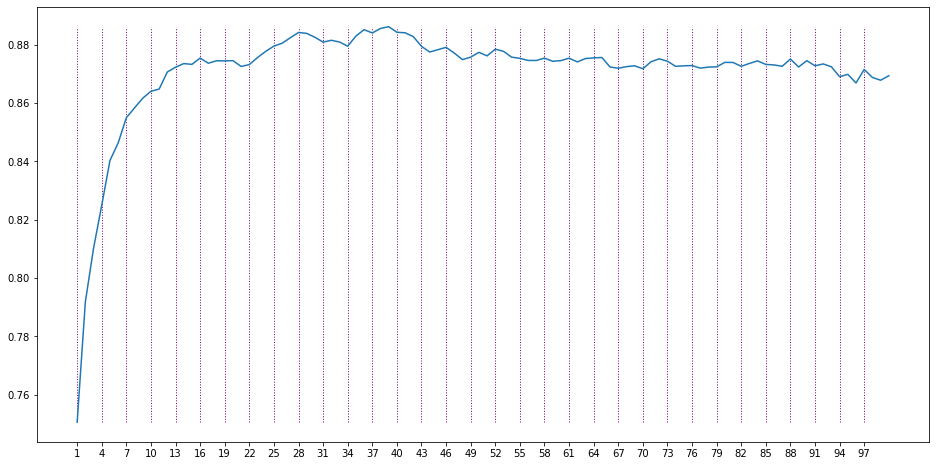

Optimal number of features:  14


('SympChck,CSC_10C',
 'SDQ,SDQ_12',
 'SDQ,SDQ_16',
 'SDQ,SDQ_29_c',
 'SRS,SRS_36',
 'SRS,SRS_61',
 'ICU_P,ICU_P_03',
 'ESWAN,MDD_8A',
 'ESWAN,SocAnx_01',
 'APQ_SR,APQ_SR_14A',
 'APQ_SR,APQ_SR_26',
 'APQ_SR,APQ_SR_31',
 'WHODAS_P,WHODAS_P_Days03',
 'CIS_SR,CIS_SR_10')

Score using all features: 
Diag: No Diagnosis Given


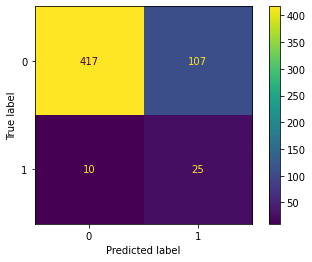

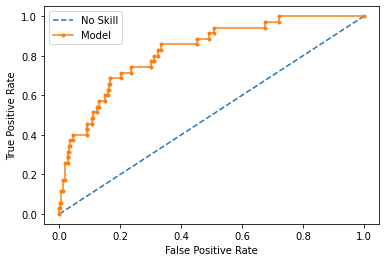

ROC AUC:  0.8256815703380589
Recall:  0.7142
Precision:  0.1894
Performance on test set using optimal number of columns: 
Diag: No Diagnosis Given


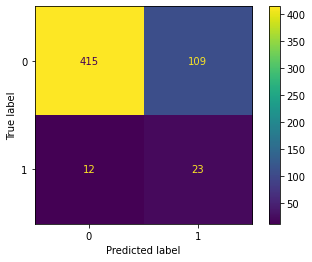

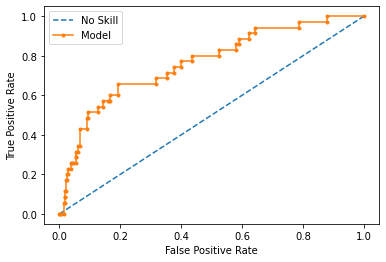

ROC AUC:  0.7665212649945474
Recall:  0.6571
Precision:  0.1743
Performance on test set using number of columns with maximum score
Diag: No Diagnosis Given


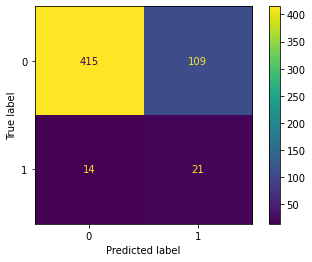

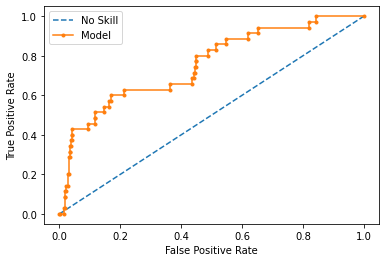

ROC AUC:  0.7564885496183206
Recall:  0.5999
Precision:  0.1616
Diag: Specific Learning Disorder with Impairment in Mathematics


,ROC AUC
1,0.634319
2,0.682388
3,0.710115
4,0.729200
5,0.748163
...,...
96,0.846155
97,0.843316
98,0.842037
99,0.842169


Max score:  0.8509648606909654  at  66  features


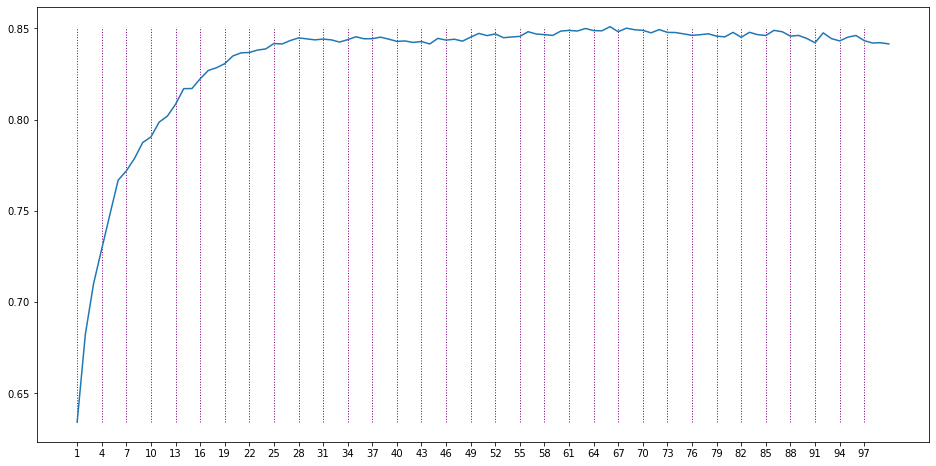

Optimal number of features:  20


('SympChck,CSC_01P',
 'SympChck,CSC_02C',
 'SCQ,SCQ_19',
 'SCQ,SCQ_32',
 'SCQ,SCQ_35',
 'ARI_P,ARI_P_02',
 'SWAN,SWAN_08',
 'SRS,SRS_30',
 'CBCL,CBCL_17',
 'APQ_P,APQ_P_28',
 'DTS,DTS_08',
 'ESWAN,DMDD_2A',
 'ESWAN,DMDD_2B',
 'MFQ_P,MFQ_P_15',
 'WHODAS_P,WHODAS_P_09',
 'WHODAS_P,WHODAS_P_Days02',
 'PSI,PSI_18',
 'RBS,RBS_25',
 'WHODAS_SR,WHODAS_SR_Days03',
 'CIS_SR,CIS_SR_05')

Score using all features: 
Diag: Specific Learning Disorder with Impairment in Mathematics


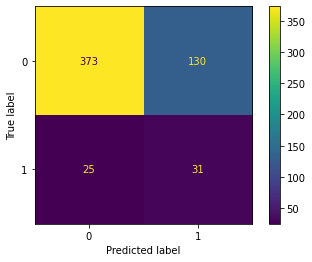

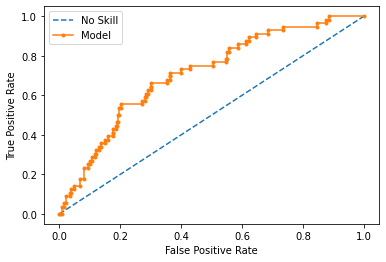

ROC AUC:  0.7102385685884691
Recall:  0.5536
Precision:  0.1926
Performance on test set using optimal number of columns: 
Diag: Specific Learning Disorder with Impairment in Mathematics


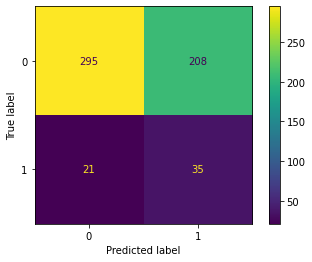

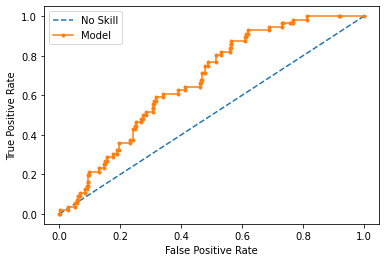

ROC AUC:  0.6744177790400454
Recall:  0.625
Precision:  0.1441
Performance on test set using number of columns with maximum score
Diag: Specific Learning Disorder with Impairment in Mathematics


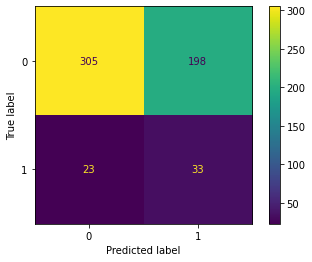

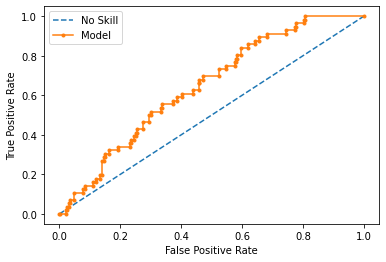

ROC AUC:  0.647472309003124
Recall:  0.5893
Precision:  0.1429


In [25]:
# Print sfs results
for diag in forward_feature_objects.keys():
    print(diag)
    
    features_up_to_optimal, features_up_to_max_score = analyze_importances(forward_feature_objects[diag].subsets_)
    features_up_to_optimal = list(features_up_to_optimal)
    features_up_to_max_score = list(features_up_to_max_score)
    
    # Test both subsets on test set
    classifier = best_classifiers[diag][0]
    threshold = best_thresholds[diag]
    
    # All features
    # Create new pipeline with the same params (need to re-train the imputer on less features)
    new_classifier = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='median'), StandardScaler(), classifier[2])
    new_classifier.fit(train_set[input_cols], train_set[diag])
    print("Score using all features: ")
    metrics = get_metrics(new_classifier, threshold, diag, input_cols, 'test', 1)
    print("ROC AUC: ", metrics[-1])
    print("Recall: ", metrics[metric_names.index("Recall")])
    print("Precision: ", metrics[metric_names.index("Precision")])
    
    # Create new pipeline with the same params (need to re-train the imputer on less features)
    new_classifier = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='median'), StandardScaler(), classifier[2])
    new_classifier.fit(train_set[features_up_to_optimal], train_set[diag])
    print("Performance on test set using optimal number of columns: ")
    metrics = get_metrics(new_classifier, threshold, diag, features_up_to_optimal, 'test', 1)
    print("ROC AUC: ", metrics[-1])
    print("Recall: ", metrics[metric_names.index("Recall")])
    print("Precision: ", metrics[metric_names.index("Precision")])

    # Create new pipeline with the same params (need to re-train the imputer on less features)
    new_classifier = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='median'), StandardScaler(), classifier[2])
    new_classifier.fit(train_set[features_up_to_max_score], train_set[diag])
    print("Performance on test set using number of columns with maximum score")
    metrics = get_metrics(new_classifier, threshold, diag, features_up_to_max_score, 'test', 1)
    print("ROC AUC: ", metrics[-1])
    print("Recall: ", metrics[metric_names.index("Recall")])
    print("Precision: ", metrics[metric_names.index("Precision")])

Diag: Obsessive-Compulsive Disorder


,ROC AUC
1,0.756249
2,0.848357
3,0.870545
4,0.887631
5,0.889248
...,...
96,0.891394
97,0.891394
98,0.891394
99,0.891394


Max score:  0.8913938452601937  at  10  features


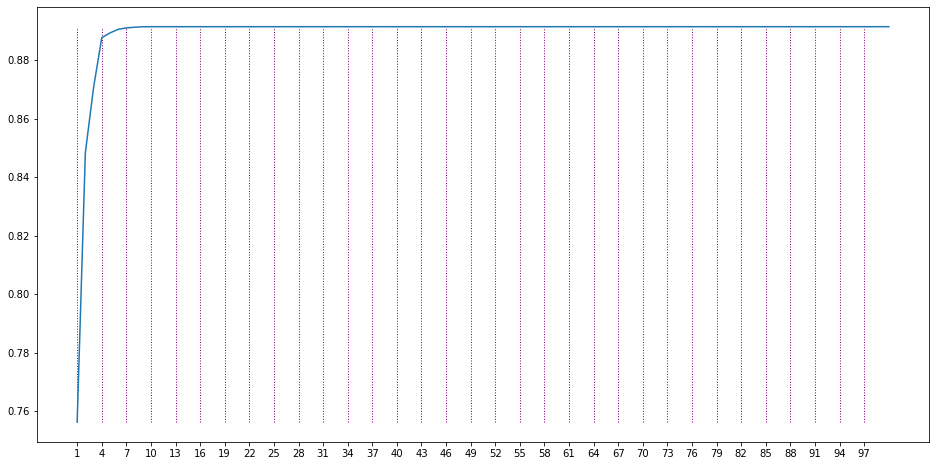

Optimal number of features:  5


('SympChck,CSC_26P',
 'SympChck,CSC_27P',
 'CBCL,CBCL_112',
 'CBCL,CBCL_66',
 'CBCL,CBCL_84')

Score using all features: 
Diag: Obsessive-Compulsive Disorder


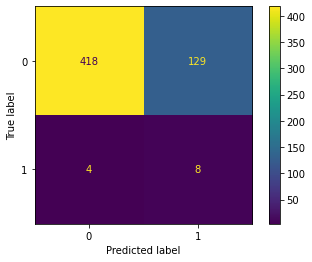

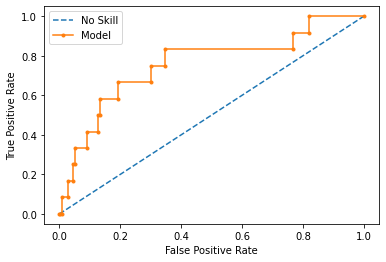

ROC AUC:  0.7571602681291895
Recall:  0.6664
Precision:  0.0585
Performance on test set using optimal number of columns: 
Diag: Obsessive-Compulsive Disorder


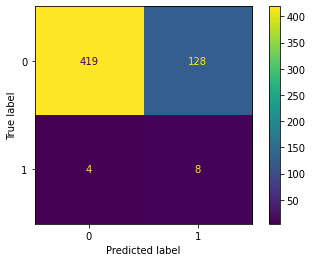

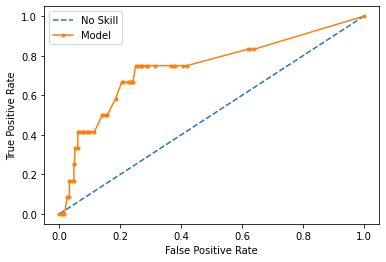

ROC AUC:  0.7407830591102986
Recall:  0.6664
Precision:  0.0589
Performance on test set using number of columns with maximum score
Diag: Obsessive-Compulsive Disorder


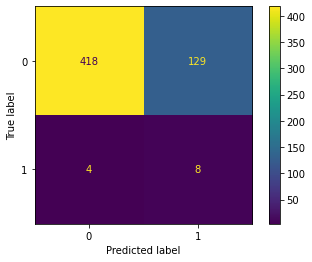

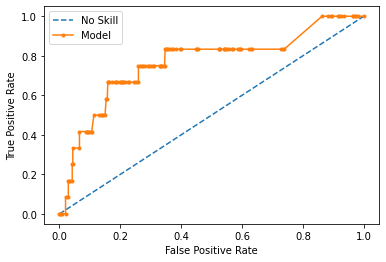

ROC AUC:  0.7643205362583791
Recall:  0.6664
Precision:  0.0585
Diag: Oppositional Defiant Disorder


,ROC AUC
1,0.807244
2,0.844839
3,0.864734
4,0.871942
5,0.879378
...,...
96,0.903177
97,0.902582
98,0.902853
99,0.903319


Max score:  0.9075729148899881  at  58  features


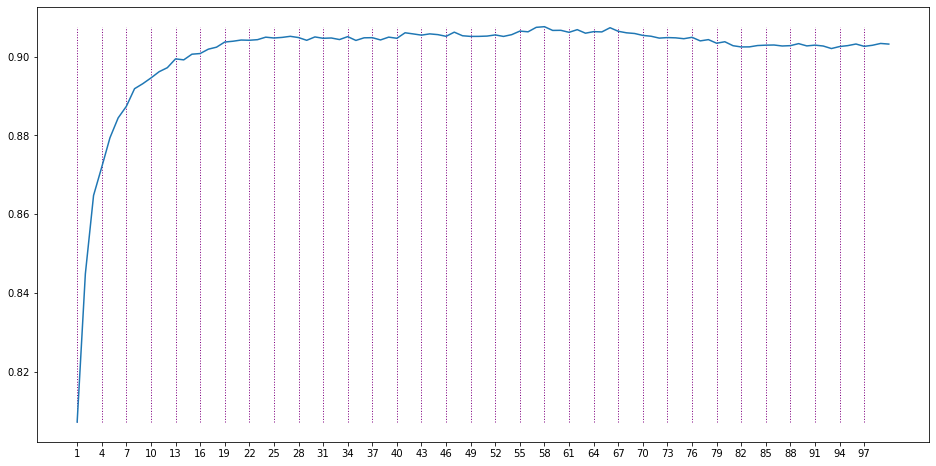

Optimal number of features:  13


('Basic_Demos,Age',
 'SympChck,CSC_39P',
 'ARI_P,ARI_P_05',
 'ARI_P,ARI_P_06',
 'SRS,SRS_53',
 'CBCL,CBCL_110',
 'CBCL,CBCL_22',
 'ICU_P,ICU_P_04',
 'APQ_P,APQ_P_04',
 'ESWAN,DMDD_3C',
 'APQ_SR,APQ_SR_26',
 'CIS_P,CIS_P_13',
 'APQ_SR,APQ_SR_20A_WAS_MISSING')

Score using all features: 
Diag: Oppositional Defiant Disorder


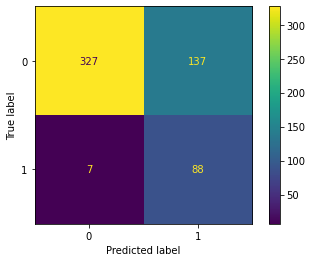

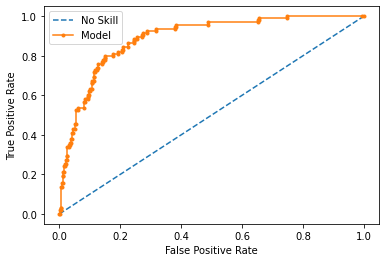

ROC AUC:  0.8894963702359346
Recall:  0.9262
Precision:  0.3911
Performance on test set using optimal number of columns: 
Diag: Oppositional Defiant Disorder


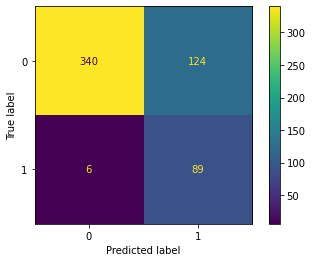

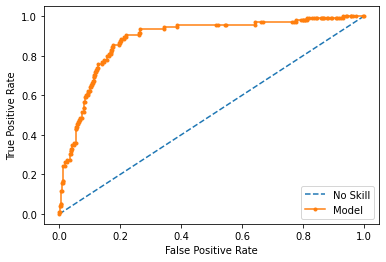

ROC AUC:  0.8847323049001816
Recall:  0.9368
Precision:  0.4178
Performance on test set using number of columns with maximum score
Diag: Oppositional Defiant Disorder


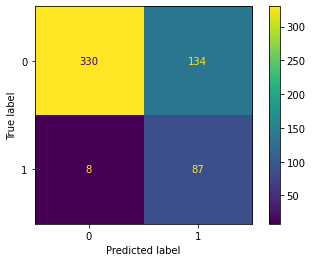

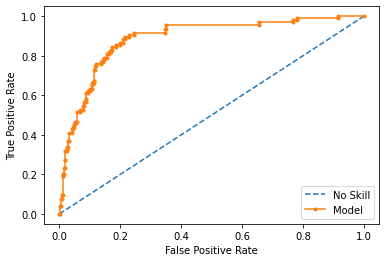

ROC AUC:  0.8879764065335752
Recall:  0.9157
Precision:  0.3937
Diag: Major Depressive Disorder


,ROC AUC
1,0.768799
2,0.830925
3,0.865884
4,0.883518
5,0.895929
...,...
96,0.914415
97,0.915071
98,0.917426
99,0.916350


Max score:  0.9225123757626924  at  35  features


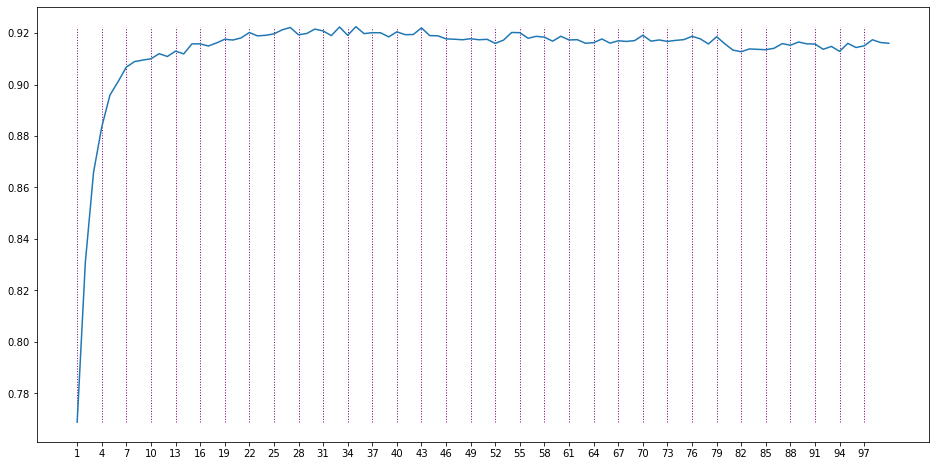

Optimal number of features:  8


('Basic_Demos,Age',
 'SympChck,CSC_01P',
 'SympChck,CSC_20P',
 'SympChck,CSC_51C',
 'SRS,SRS_37',
 'CBCL,CBCL_103',
 'APQ_SR,APQ_SR_11',
 'APQ_SR,APQ_SR_26')

Score using all features: 
Diag: Major Depressive Disorder


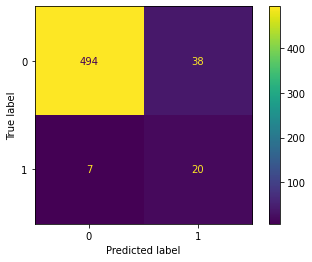

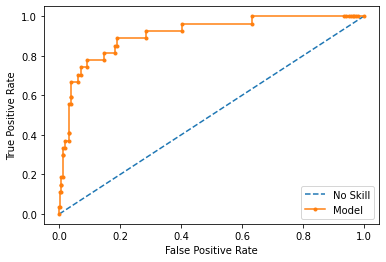

ROC AUC:  0.9105402394876079
Recall:  0.7406
Precision:  0.3449
Performance on test set using optimal number of columns: 
Diag: Major Depressive Disorder


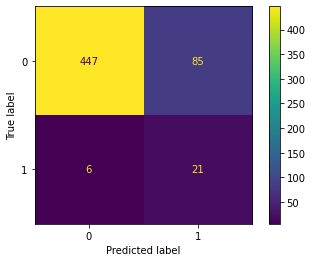

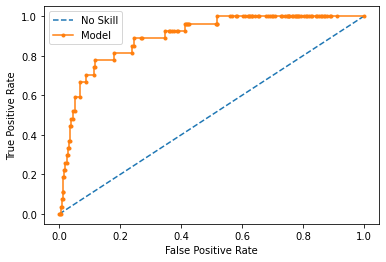

ROC AUC:  0.8957115009746589
Recall:  0.7776
Precision:  0.1982
Performance on test set using number of columns with maximum score
Diag: Major Depressive Disorder


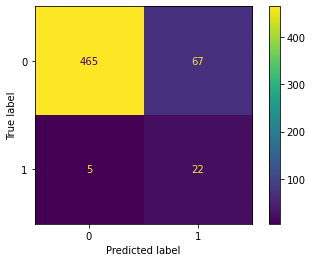

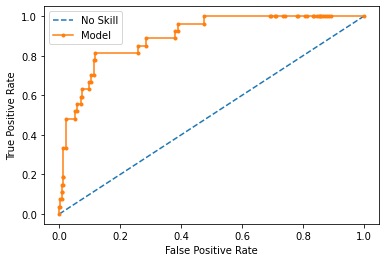

ROC AUC:  0.8977304372041214
Recall:  0.8146
Precision:  0.2472
Diag: Enuresis


,ROC AUC
1,0.826854
2,0.905570
3,0.928670
4,0.936036
5,0.940860
...,...
96,0.957370
97,0.957557
98,0.958224
99,0.958202


Max score:  0.9615429324049692  at  39  features


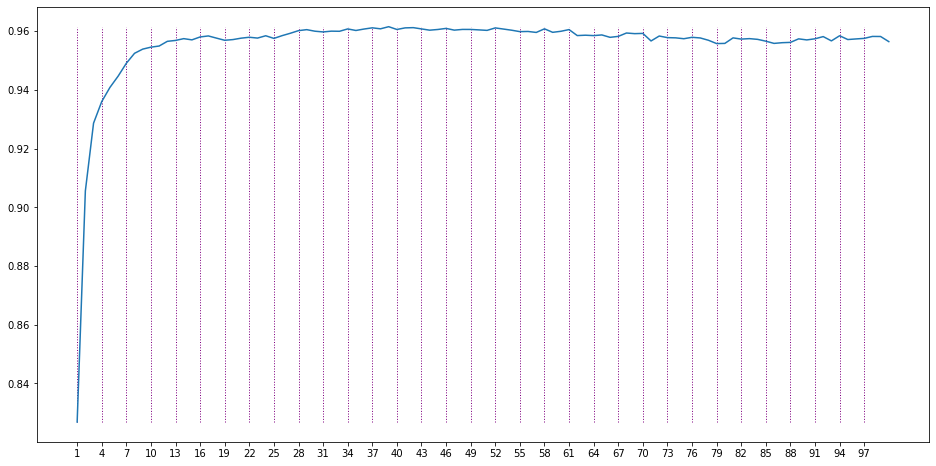

Optimal number of features:  9


('SympChck,CSC_28P',
 'SympChck,CSC_37P',
 'ASSQ,ASSQ_01',
 'SRS,SRS_19',
 'CBCL,CBCL_09',
 'CBCL,CBCL_108',
 'APQ_P,APQ_P_02',
 'MFQ_P,MFQ_P_17',
 'APQ_SR,APQ_SR_26A')

Score using all features: 
Diag: Enuresis


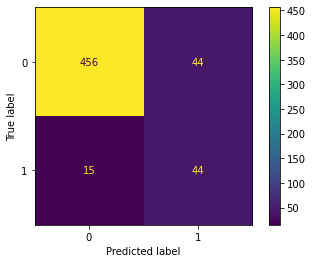

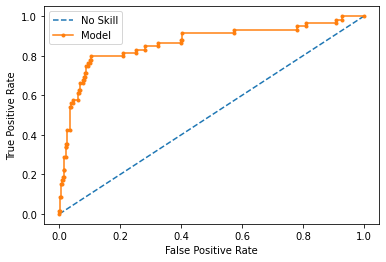

ROC AUC:  0.865322033898305
Recall:  0.7457
Precision:  0.5
Performance on test set using optimal number of columns: 
Diag: Enuresis


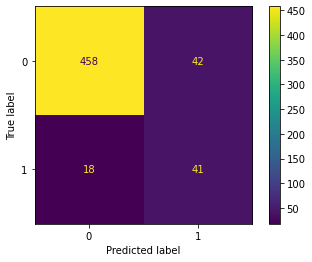

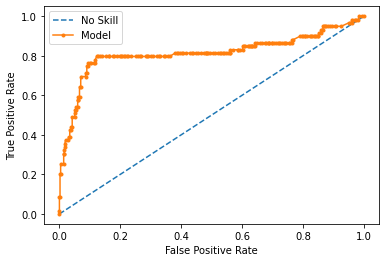

ROC AUC:  0.8148983050847458
Recall:  0.6948
Precision:  0.494
Performance on test set using number of columns with maximum score
Diag: Enuresis


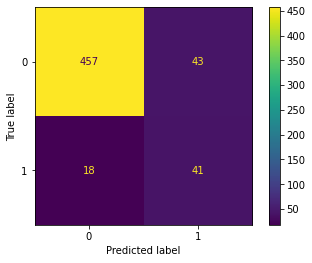

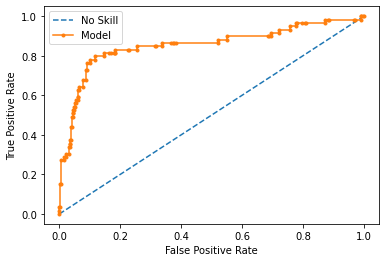

ROC AUC:  0.8541694915254237
Recall:  0.6948
Precision:  0.4881
Diag: Language Disorder


,ROC AUC
1,0.628864
2,0.685722
3,0.714916
4,0.742584
5,0.754219
...,...
96,0.809915
97,0.811930
98,0.812984
99,0.808976


Max score:  0.8171344688151798  at  36  features


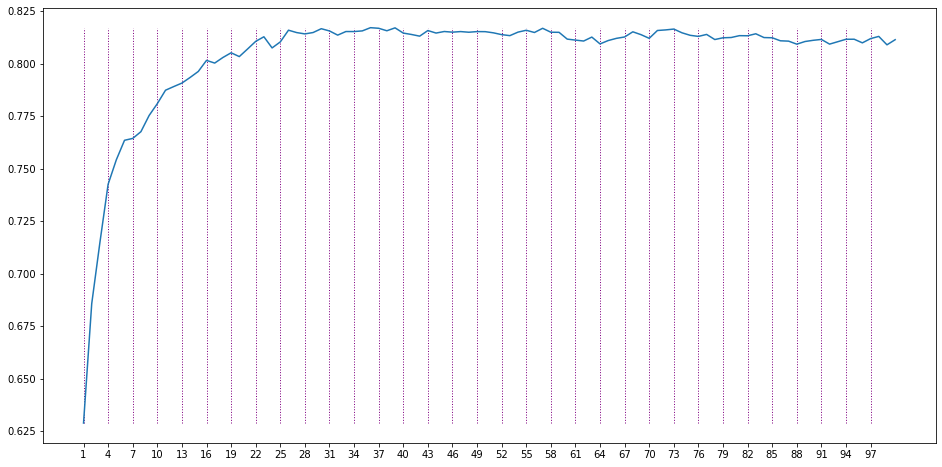

Optimal number of features:  16


('Basic_Demos,Age',
 'SCQ,SCQ_02',
 'SCQ,SCQ_24',
 'SDQ,SDQ_13',
 'SRS,SRS_49',
 'CBCL,CBCL_57',
 'CBCL,CBCL_79',
 'ICU_P,ICU_P_12',
 'APQ_P,APQ_P_03',
 'APQ_P,APQ_P_31',
 'ESWAN,DMDD_10A',
 'APQ_SR,APQ_SR_04A',
 'APQ_SR,APQ_SR_37',
 'WHODAS_P,WHODAS_P_Days02',
 'PSI,PSI_18',
 'RBS,RBS_11')

Score using all features: 
Diag: Language Disorder


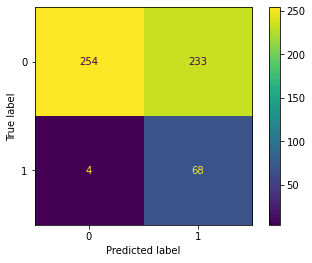

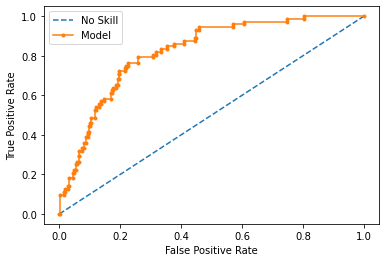

ROC AUC:  0.8219826602783482
Recall:  0.9443
Precision:  0.2259
Performance on test set using optimal number of columns: 
Diag: Language Disorder


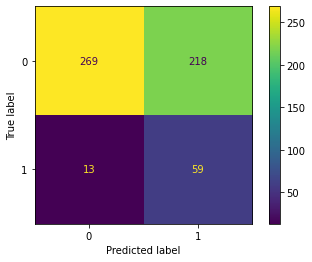

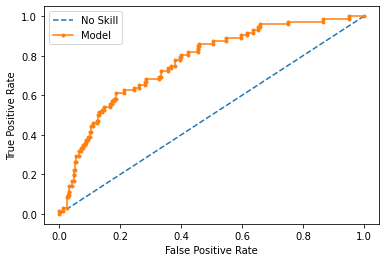

ROC AUC:  0.7687086470454026
Recall:  0.8194
Precision:  0.213
Performance on test set using number of columns with maximum score
Diag: Language Disorder


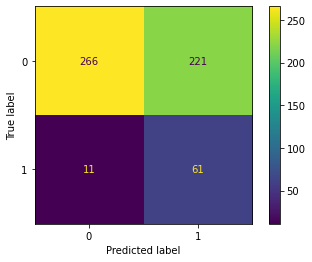

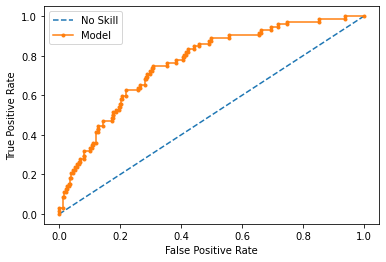

ROC AUC:  0.7641170431211498
Recall:  0.8471
Precision:  0.2163
Diag: Separation Anxiety


,ROC AUC
1,0.731390
2,0.772415
3,0.803577
4,0.815412
5,0.824361
...,...
96,0.884646
97,0.884646
98,0.884646
99,0.884646


Max score:  0.8846462930131963  at  85  features


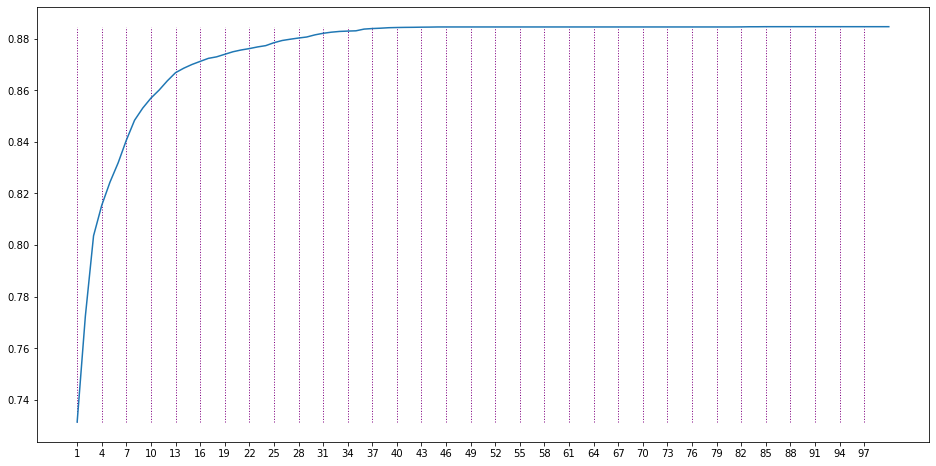

Optimal number of features:  14


('SympChck,CSC_16C',
 'SympChck,CSC_17P',
 'SympChck,CSC_42C',
 'SCQ,SCQ_39',
 'SRS,SRS_01',
 'SRS,SRS_35',
 'SRS,SRS_43',
 'CBCL,CBCL_03',
 'CBCL,CBCL_112',
 'DTS,DTS_14',
 'APQ_SR,APQ_SR_25',
 'CIS_P,CIS_P_08',
 'CIS_P,CIS_P_10',
 'RBS,RBS_34')

Score using all features: 
Diag: Separation Anxiety


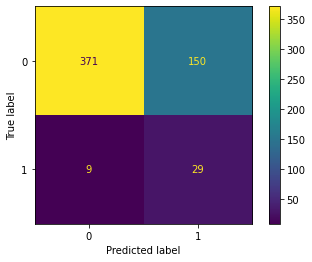

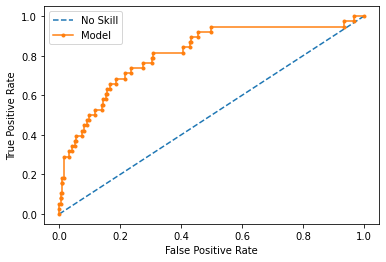

ROC AUC:  0.8121022325487421
Recall:  0.763
Precision:  0.162
Performance on test set using optimal number of columns: 
Diag: Separation Anxiety


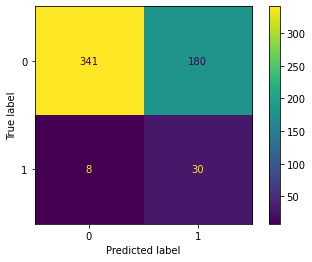

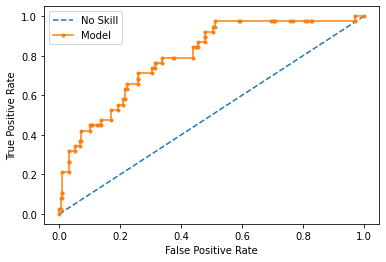

ROC AUC:  0.7941711283968078
Recall:  0.7893
Precision:  0.1429
Performance on test set using number of columns with maximum score
Diag: Separation Anxiety


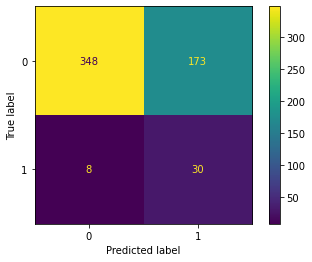

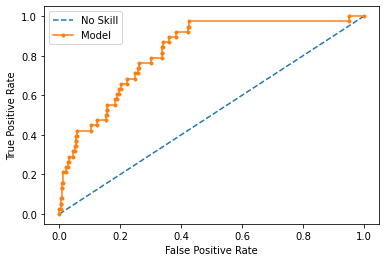

ROC AUC:  0.8232649762602283
Recall:  0.7893
Precision:  0.1478
Diag: ADHD-Combined Type


,ROC AUC
1,0.790049
2,0.845262
3,0.854728
4,0.861977
5,0.868440
...,...
96,0.891239
97,0.890517
98,0.890569
99,0.890638


Max score:  0.891830485912779  at  92  features


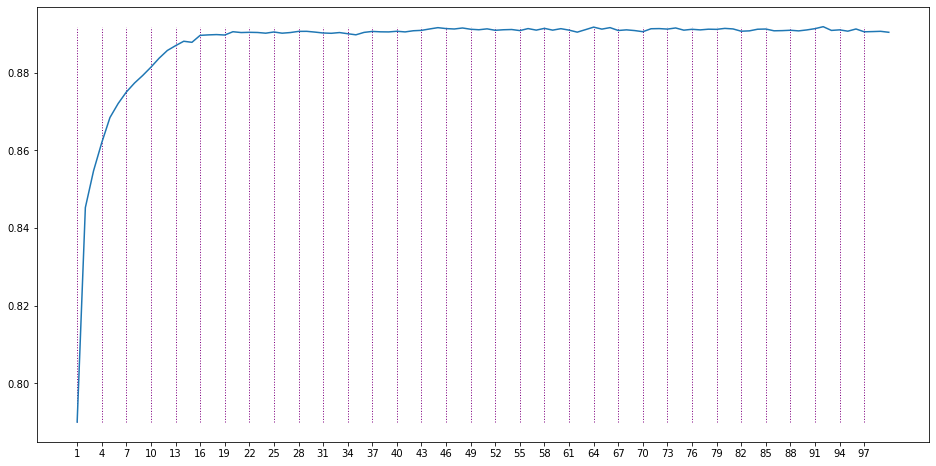

Optimal number of features:  14


('SympChck,CSC_36P',
 'SympChck,CSC_44P',
 'SCQ,SCQ_09',
 'SDQ,SDQ_02',
 'SDQ,SDQ_29_c',
 'SWAN,SWAN_04',
 'SWAN,SWAN_14',
 'SWAN,SWAN_16',
 'SWAN,SWAN_18',
 'SRS,SRS_42',
 'SRS,SRS_55',
 'CBCL,CBCL_63',
 'APQ_P,APQ_P_05',
 'MFQ_P,MFQ_P_12')

Score using all features: 
Diag: ADHD-Combined Type


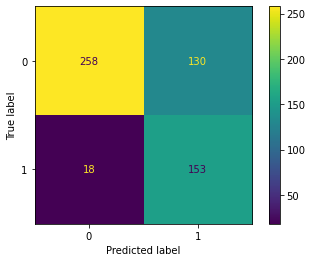

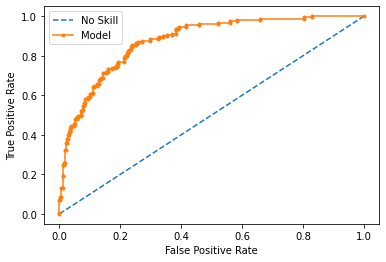

ROC AUC:  0.876529812503768
Recall:  0.8947
Precision:  0.5406
Performance on test set using optimal number of columns: 
Diag: ADHD-Combined Type


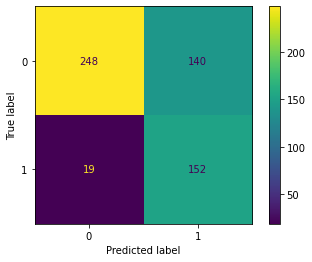

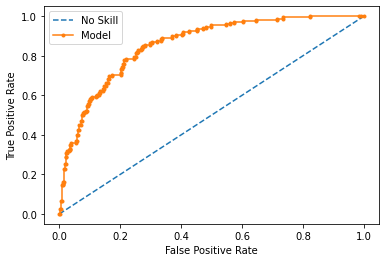

ROC AUC:  0.856348345089528
Recall:  0.8888
Precision:  0.5205
Performance on test set using number of columns with maximum score
Diag: ADHD-Combined Type


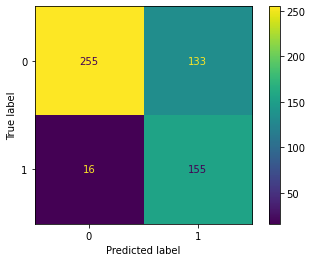

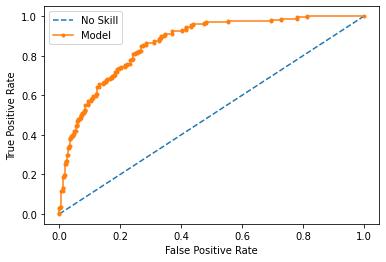

ROC AUC:  0.864442032917345
Recall:  0.9064
Precision:  0.5382
Diag: Social Anxiety (Social Phobia)


,ROC AUC
1,0.728378
2,0.772817
3,0.797730
4,0.813867
5,0.823580
...,...
96,0.873888
97,0.873096
98,0.873567
99,0.874906


Max score:  0.876496744685391  at  86  features


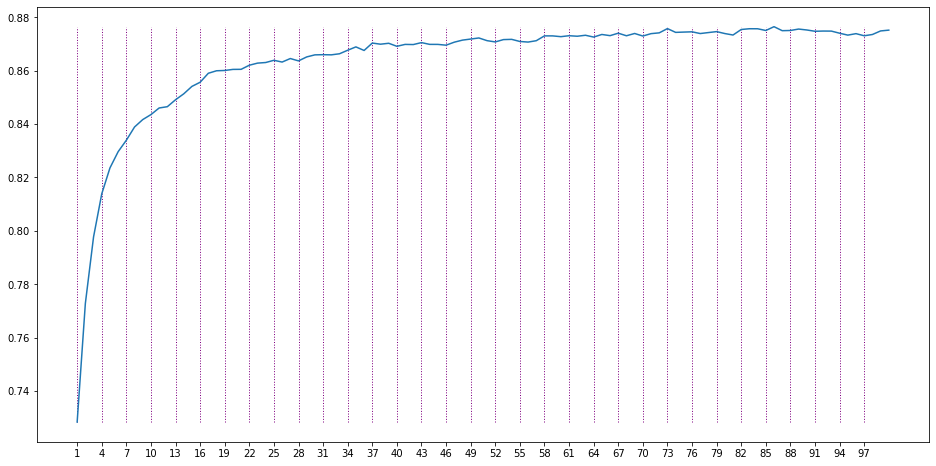

Optimal number of features:  17


('SympChck,CSC_20P',
 'SympChck,CSC_36C',
 'SympChck,CSC_40C',
 'SympChck,CSC_52P',
 'SCQ,SCQ_11',
 'SCQ,SCQ_16',
 'CBCL,CBCL_07',
 'CBCL,CBCL_30',
 'CBCL,CBCL_35',
 'CBCL,CBCL_64',
 'CBCL,CBCL_65',
 'CBCL,CBCL_75',
 'APQ_P,APQ_P_40',
 'DTS,DTS_08',
 'APQ_SR,APQ_SR_07A',
 'PSI,PSI_10',
 'RBS,RBS_26')

Score using all features: 
Diag: Social Anxiety (Social Phobia)


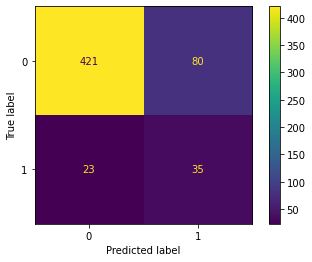

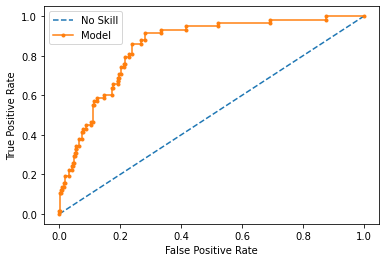

ROC AUC:  0.8495767086516621
Recall:  0.6034
Precision:  0.3044
Performance on test set using optimal number of columns: 
Diag: Social Anxiety (Social Phobia)


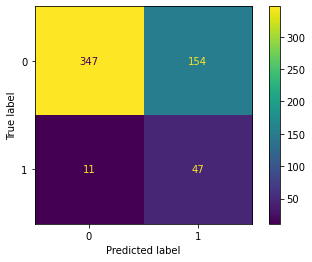

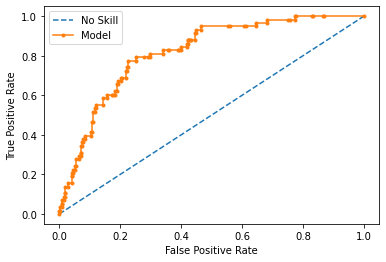

ROC AUC:  0.8188106545529631
Recall:  0.8102
Precision:  0.2339
Performance on test set using number of columns with maximum score
Diag: Social Anxiety (Social Phobia)


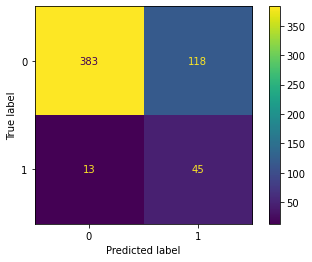

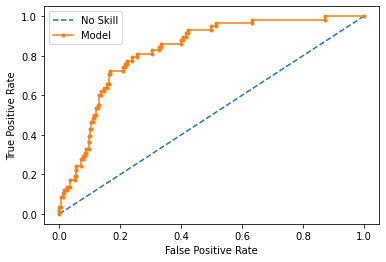

ROC AUC:  0.829651042742102
Recall:  0.7758
Precision:  0.2761
Diag: Autism Spectrum Disorder


,ROC AUC
1,0.791042
2,0.838716
3,0.863212
4,0.875144
5,0.883733
...,...
96,0.944402
97,0.944473
98,0.944573
99,0.944587


Max score:  0.9446578389132299  at  100  features


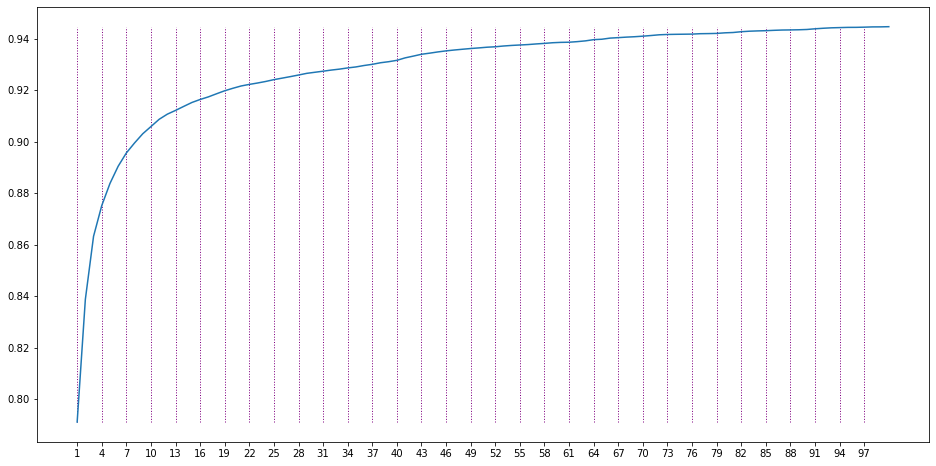

Optimal number of features:  12


('Basic_Demos,Sex',
 'SympChck,CSC_48P',
 'SympChck,CSC_51P',
 'SCQ,SCQ_13',
 'ASSQ,ASSQ_03',
 'SRS,SRS_10',
 'SRS,SRS_22',
 'SRS,SRS_33',
 'CBCL,CBCL_28',
 'APQ_P,APQ_P_34',
 'RBS,RBS_44',
 'WHODAS_SR,WHODAS_SR_04')

Score using all features: 
Diag: Autism Spectrum Disorder


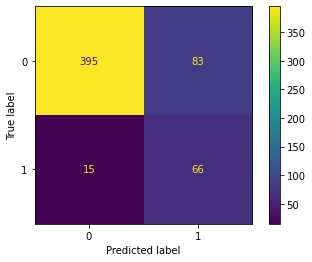

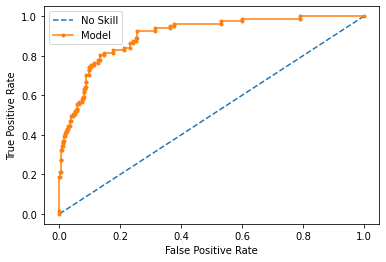

ROC AUC:  0.9046438349088278
Recall:  0.8147
Precision:  0.443
Performance on test set using optimal number of columns: 
Diag: Autism Spectrum Disorder


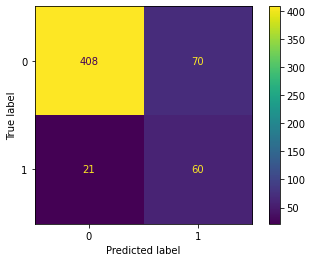

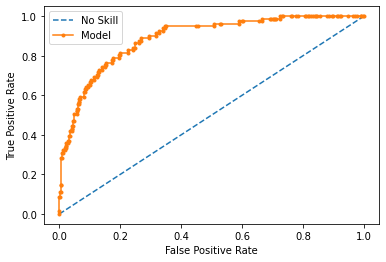

ROC AUC:  0.8888372333281678
Recall:  0.7407
Precision:  0.4615
Performance on test set using number of columns with maximum score
Diag: Autism Spectrum Disorder


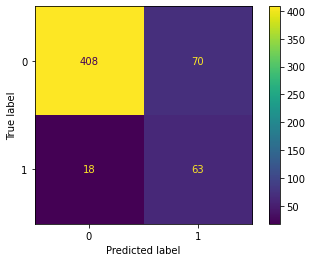

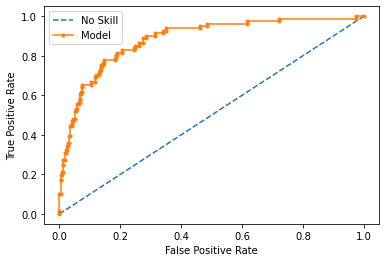

ROC AUC:  0.883878299498941
Recall:  0.7777
Precision:  0.4737


In [25]:
# Feature importances of the rest of the diganoses

if IMPORTANCES_FROM_FILE == 0:
    forward_feature_subsets_rest = {}
    forward_feature_objects_rest = {}
    for diag in [x for x in diags_with_good_performance if x not in forward_feature_objects.keys()]: # Rest of the diagnoses
        print(diag)
        diag_classifier = best_classifiers[diag][0]

        cv = StratifiedKFold(n_splits=3)
        sfs = SequentialFeatureSelector(diag_classifier, 
              k_features=100,
              forward=True, 
              scoring='roc_auc',
              cv=cv,
              n_jobs=-1)

        sfs = sfs.fit(train_set[input_cols], train_set[diag])

        forward_feature_subsets_rest[diag] = sfs.subsets_
        forward_feature_objects_rest[diag] = sfs
        
        #analyze_importances(forward_feature_objects_rest[diag].subsets_)
        
        # Save importances to file
        dump(forward_feature_objects_rest, 'forward-sfs-diag-rest-item-lvl.joblib', compress=1)
        
        # Print results
        features_up_to_optimal, features_up_to_max_score = analyze_importances(forward_feature_objects_rest[diag].subsets_)
        features_up_to_optimal = list(features_up_to_optimal)
        features_up_to_max_score = list(features_up_to_max_score)

        # Test both subsets on test set
        classifier = best_classifiers[diag][0]
        threshold = best_thresholds[diag]

        # All features
        # Create new pipeline with the same params (need to re-train the imputer on less features)
        new_classifier = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='median'), StandardScaler(), classifier[2])
        new_classifier.fit(train_set[input_cols], train_set[diag])
        print("Score using all features: ")
        metrics = get_metrics(new_classifier, threshold, diag, input_cols, 'test', 1)
        print("ROC AUC: ", metrics[-1])
        print("Recall: ", metrics[metric_names.index("Recall")])
        print("Precision: ", metrics[metric_names.index("Precision")])

        # Create new pipeline with the same params (need to re-train the imputer on less features)
        new_classifier = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='median'), StandardScaler(), classifier[2])
        new_classifier.fit(train_set[features_up_to_optimal], train_set[diag])
        print("Performance on test set using optimal number of columns: ")
        metrics = get_metrics(new_classifier, threshold, diag, features_up_to_optimal, 'test', 1)
        print("ROC AUC: ", metrics[-1])
        print("Recall: ", metrics[metric_names.index("Recall")])
        print("Precision: ", metrics[metric_names.index("Precision")])

        # Create new pipeline with the same params (need to re-train the imputer on less features)
        new_classifier = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='median'), StandardScaler(), classifier[2])
        new_classifier.fit(train_set[features_up_to_max_score], train_set[diag])
        print("Performance on test set using number of columns with maximum score")
        metrics = get_metrics(new_classifier, threshold, diag, features_up_to_max_score, 'test', 1)
        print("ROC AUC: ", metrics[-1])
        print("Recall: ", metrics[metric_names.index("Recall")])
        print("Precision: ", metrics[metric_names.index("Precision")])